In [1]:
import h5py
import numpy as np
import pandas as pd
import scipy
from scipy import signal
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn import metrics
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
#from tqdm import tqdm
import warnings
warnings.filterwarnings('ignore')

2023-04-13 14:23:51.001091: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
def getData(cfileName):

    # Read the *.cfile which has each element in float32 format.
    data = np.fromfile(cfileName, dtype="float32")

    # Take each consecutive interleaved I sample and Q sample to create a single complex element.
    data = data[0::2] + 1j*data[1::2]
    #print("data type=", type(data))
    # Return the complex numpy array.
    return data

def create_dataset(data, class_label):
    f, t, Zxx = signal.stft(data, fs=20e6, nperseg=fft_size, noverlap=fft_overlap)
    print(len(f))
    print(len(t))
    print(Zxx.shape)

    del data

    Zxx = Zxx.transpose()

    Zxx = abs(Zxx)
    # scaling the features (only real part of the data can be used)
    scaler = MinMaxScaler()
    scaler.fit(Zxx)
    print(scaler.data_max_)
    Zxx = scaler.transform(Zxx)

    X = Zxx[:num_samp_per_class]
    Y = np.full(num_samp_per_class, class_label)

    return X, Y

# number of samples per class
num_samp_per_class = 10000

# FFT size for the STFT operation (which is same as the feature vector size)
fft_size = feature_vector_size = 2048 #1024

# number of overlapping samples for the STFT operation
fft_overlap = 256

## Nordic Device-25(v) dataset

In [3]:
class_label = 8
for i in range(class_label):

    folder_path = "/Volumes/Transcend/PhD in Computing/Data Collection/Nordic/32MHz/Device-25(v)/"

    if(i==0):
        data = getData(folder_path + "BLINK_new.cfile")
        print(np.array(data))
        X, Y = create_dataset(data, i)

    else:

        if(i==1):
            data = getData(folder_path + "blinky_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==2):
            data = getData(folder_path + "blinky_rtc_freertos.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==3):
            data = getData(folder_path + "blinky_systick.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==4):
            data = getData(folder_path + "blinky.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==5):
            data = getData(folder_path + "IDLE_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==6):
            data = getData(folder_path + "led_softblink.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        if(i==7):
            data = getData(folder_path + "Matrix_MUL_new.cfile")
            print(np.array(data))
            dataset, label = create_dataset(data, i)

        X = np.concatenate((X, dataset), axis=0) 
        Y = np.concatenate((Y, label), axis=0)
        
    print(i)
    print(X.shape)
    print(Y.shape)

# combine all em signals into one dataframe
em_data = pd.DataFrame(X)
em_data.insert(len(em_data.columns), 'labels', Y)

# save to csv file
#(em_data.T).to_csv(f'/Users/Lojenaa/Documents/DELL_Linux/Lojenaa/HackRF One/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone6S/i6S_I.csv', header=False)
# (em_data.T).to_csv(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Smartphones/iPhone/iPhone8/i8_I.csv', header=False)

[-0.015625 -0.0546875j  0.       +0.0390625j  0.03125  -0.1171875j ...
 -0.0078125+0.03125j    0.0546875-0.0234375j  0.0546875-0.078125j ]
2048
93040
(2048, 93040)
[0.02503357 0.01491655 0.00578485 ... 0.00497458 0.00474863 0.01464237]
0
(10000, 2048)
(10000,)
[ 0.015625 -0.0234375j  0.0546875-0.0078125j -0.015625 -0.0234375j ...
  0.0546875+0.03125j    0.09375  -0.046875j   0.0546875+0.078125j ]
2048
87043
(2048, 87043)
[0.02526503 0.01516426 0.00564226 ... 0.00574531 0.00514731 0.01459226]
1
(20000, 2048)
(20000,)
[-0.0390625+0.0078125j -0.0234375+0.0703125j  0.0859375-0.046875j  ...
  0.046875 -0.015625j   0.0390625-0.015625j  -0.078125 +0.03125j  ]
2048
86603
(2048, 86603)
[0.0257653  0.01548399 0.0051004  ... 0.00480043 0.00490231 0.01504519]
2
(30000, 2048)
(30000,)
[-0.0390625+0.046875j   0.0078125+0.046875j   0.046875 -0.046875j  ...
  0.046875 -0.1640625j -0.015625 +0.109375j  -0.015625 +0.0546875j]
2048
81556
(2048, 81556)
[0.02530597 0.0146407  0.00445778 ... 0.00496841 0.00

## Cross-model Validation applying the Model of other set of samples

Nordic Device-25(i) model to Nordic Device-25(v) dataset 

In [4]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")

2023-04-13 14:39:47.252058: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [5]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.4798 - accuracy: 0.1353
test loss, test acc: [5.479778289794922, 0.1352750062942505]


In [6]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 2 ... 2 5 5]
5
[[   1    0 4648    5   16 5128  189   13]
 [   1    0 6390    6   39 3251  308    5]
 [   0    0 5649    7   25 4107  200   12]
 [   1    0 5033    8   15 4604  324   15]
 [   0    0 4470    7    6 5434   68   15]
 [   1    0 4775    7   41 5043  125    8]
 [   0    0 6265    8    6 3626   84   11]
 [   0    0 2948    3    4 6520  494   31]]
              precision    recall  f1-score   support

           0       0.25      0.00      0.00     10000
           1       0.00      0.00      0.00     10000
           2       0.14      0.56      0.23     10000
           3       0.16      0.00      0.00     10000
           4       0.04      0.00      0.00     10000
           5       0.13      0.50      0.21     10000
           6       0.05      0.01      0.01     10000
           7       0.28      0.00      0.01     10000

    accuracy                           0.14     80000
   macro avg       0.13      0.14  

Test Accuracy:0.135275


Text(0.5, 1.0, 'Accuracy:0.135')

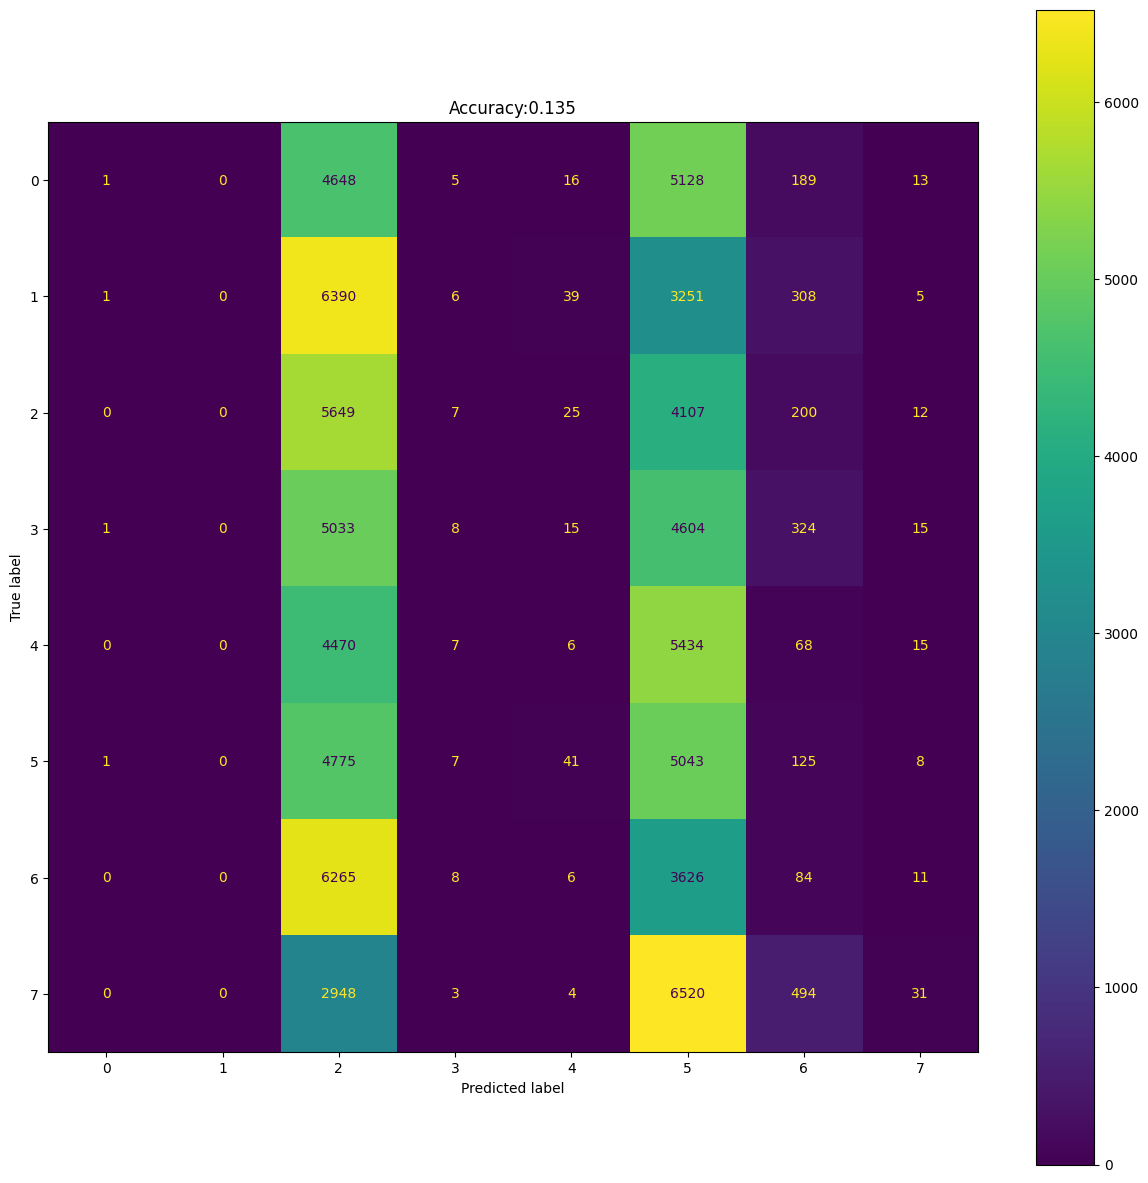

In [7]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(i) model to Nordic Device-25(v) dataset 

In [8]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [9]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [10]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.7965 - accuracy: 0.1309
Epoch 2/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.2320 - accuracy: 0.1561
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.0821 - accuracy: 0.1881
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.0171 - accuracy: 0.2105
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9789 - accuracy: 0.2296
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9535 - accuracy: 0.2463
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9348 - accuracy: 0.2576
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9204 - accuracy: 0.2673
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9088 - accuracy: 0.2745
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.89

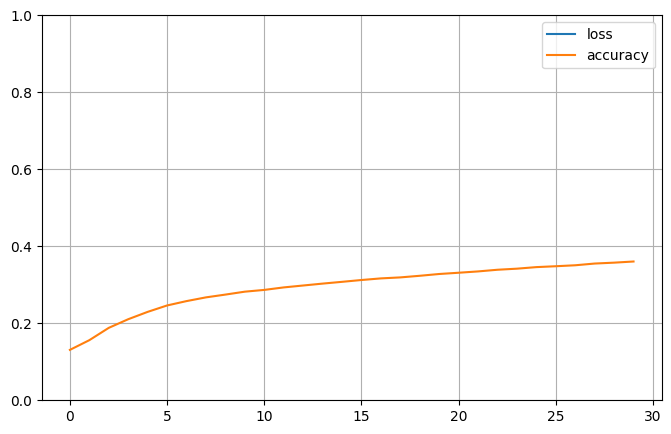

In [11]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [12]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.7705 - accuracy: 0.3612
test loss, test acc: [1.7704646587371826, 0.3612000048160553]


In [13]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[7 4 5 ... 6 7 7]
7
[[ 924  953  243  875 1725 1905 1568 1807]
 [ 131 6046  147  347  610  607 1077 1035]
 [ 350 1657  806  896 1130 1553 1994 1614]
 [ 411 1244  178 2583 1072 1180 1543 1789]
 [ 469  730  196  598 3469 1877 1479 1182]
 [ 431 1127  300  544 1649 3329 1363 1257]
 [ 300  957  141  579 1115 1032 4906  970]
 [ 172  843  115  312  533  587  605 6833]]
              precision    recall  f1-score   support

           0       0.29      0.09      0.14     10000
           1       0.45      0.60      0.51     10000
           2       0.38      0.08      0.13     10000
           3       0.38      0.26      0.31     10000
           4       0.31      0.35      0.33     10000
           5       0.28      0.33      0.30     10000
           6       0.34      0.49      0.40     10000
           7       0.41      0.68      0.52     10000

    accuracy                           0.36     80000
   macro avg       0.35      0.36  

Test Accuracy:0.3612


Text(0.5, 1.0, 'Accuracy:0.361')

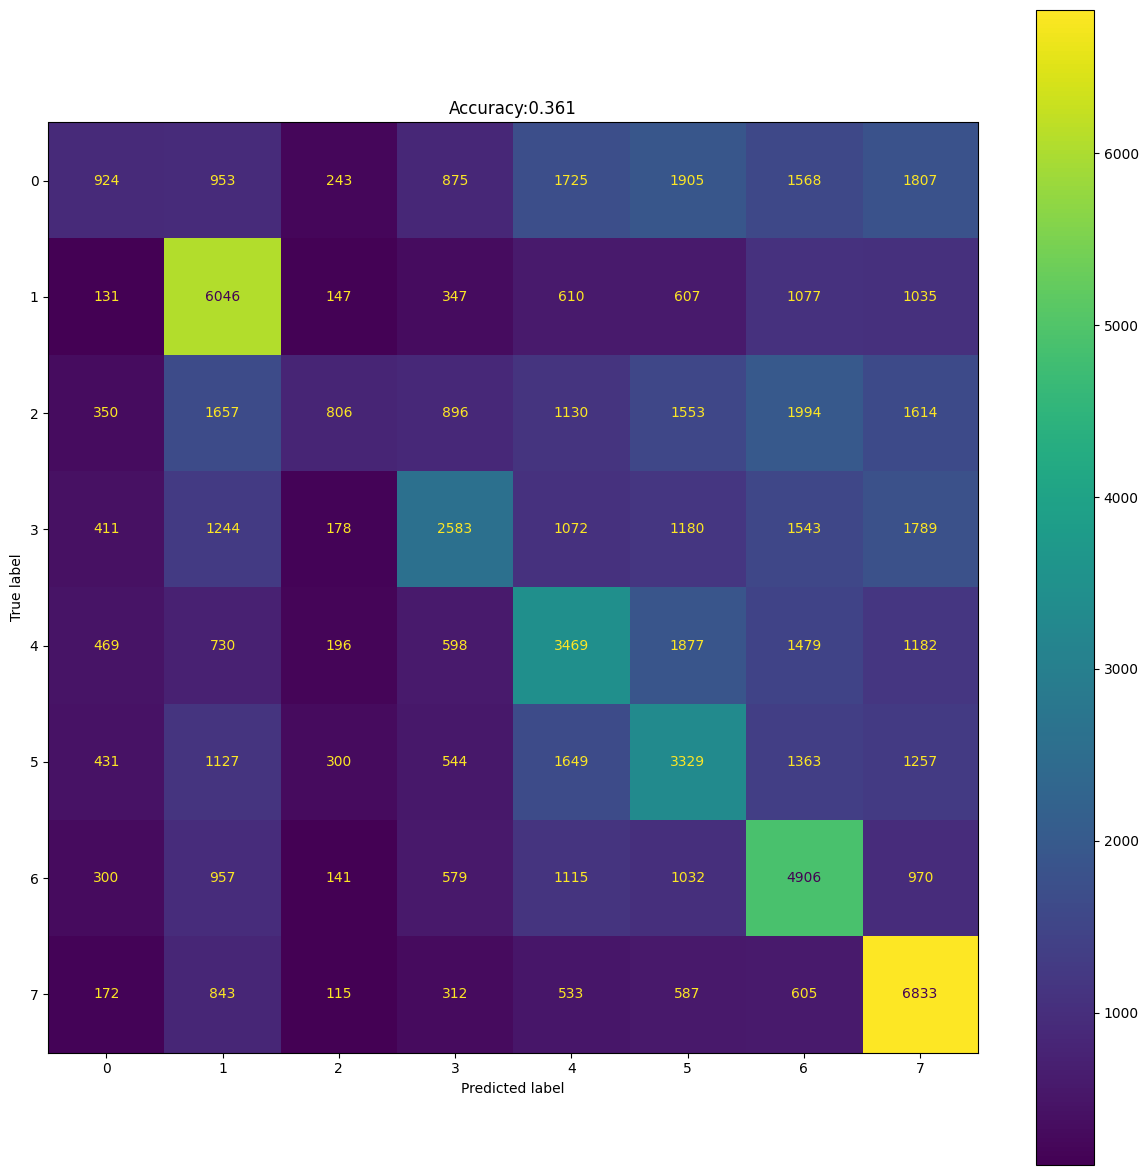

In [14]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(ii) model to Nordic Device-25(v) dataset 

In [15]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")

In [16]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.9689 - accuracy: 0.1353
test loss, test acc: [5.9688897132873535, 0.1352500021457672]


In [17]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 2 5 ... 2 5 5]
2
[[  30    2 3694    0    0 5548  704   22]
 [  36    5 3765    0    4 5089 1001  100]
 [  11    2 4219    0    0 4741 1021    6]
 [  43    1 4900    0    0 4464  573   19]
 [  25    0 3296    0    0 5909  760   10]
 [  17    1 4112    0    1 5340  518   11]
 [   7    4 4548    0    1 4214 1220    6]
 [  19    6 1940    0    0 7245  784    6]]
              precision    recall  f1-score   support

           0       0.16      0.00      0.01     10000
           1       0.24      0.00      0.00     10000
           2       0.14      0.42      0.21     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.53      0.20     10000
           6       0.19      0.12      0.15     10000
           7       0.03      0.00      0.00     10000

    accuracy                           0.14     80000
   macro avg       0.11      0.14   

Test Accuracy:0.13525


Text(0.5, 1.0, 'Accuracy:0.135')

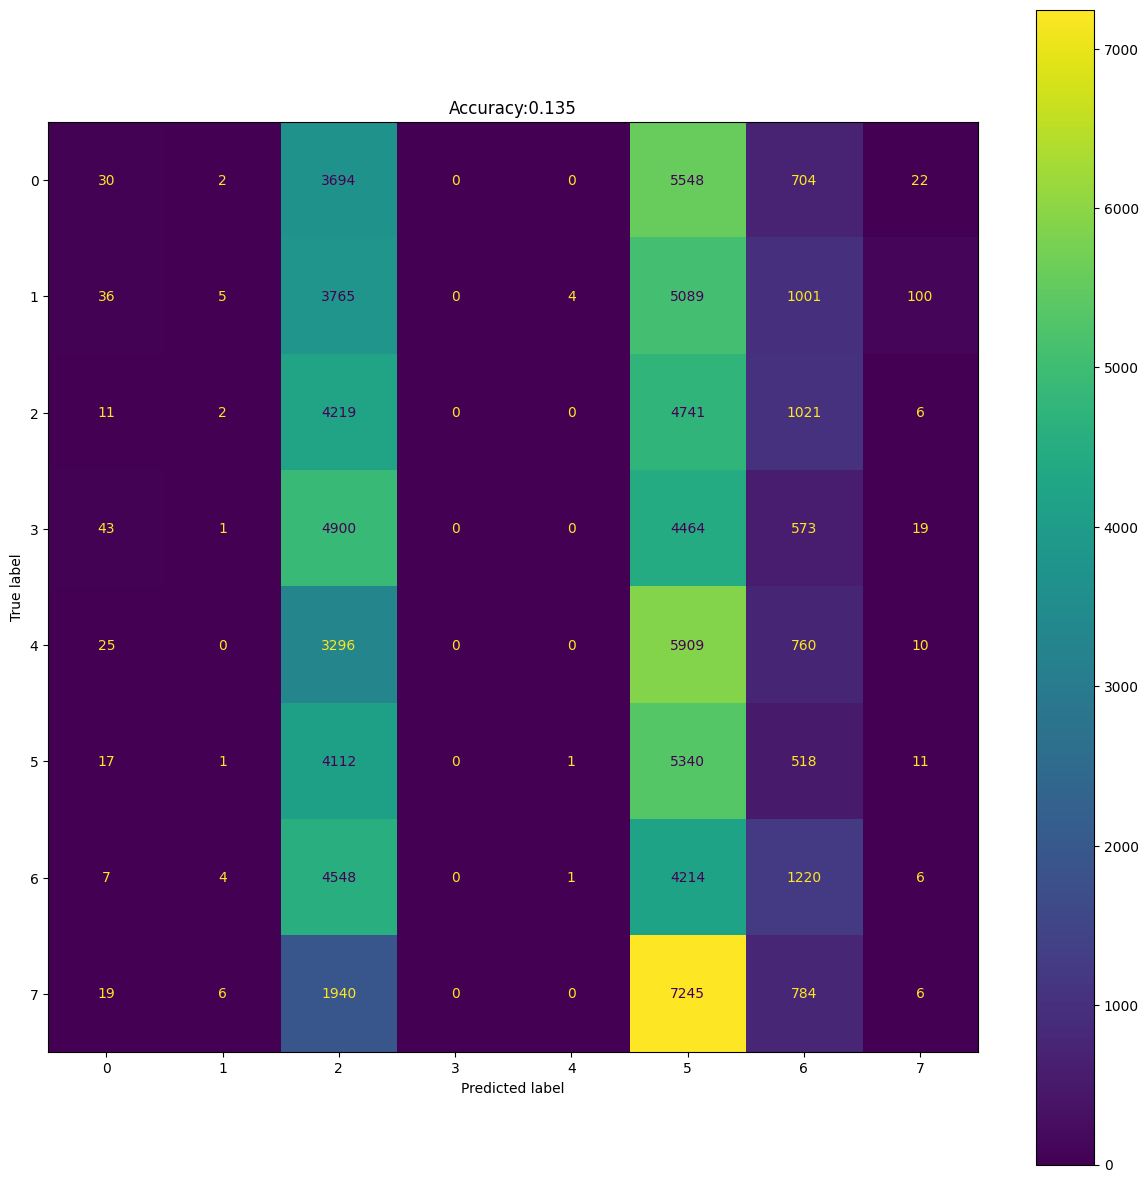

In [18]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(ii) model to Nordic Device-25(v) dataset 

In [19]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [20]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [21]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 2.8302 - accuracy: 0.1442
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.2237 - accuracy: 0.1654
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.0580 - accuracy: 0.1916
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 2.0003 - accuracy: 0.2228
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9703 - accuracy: 0.2439
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9508 - accuracy: 0.2578
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9364 - accuracy: 0.2680
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9235 - accuracy: 0.2772
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9133 - accuracy: 0.2833
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9

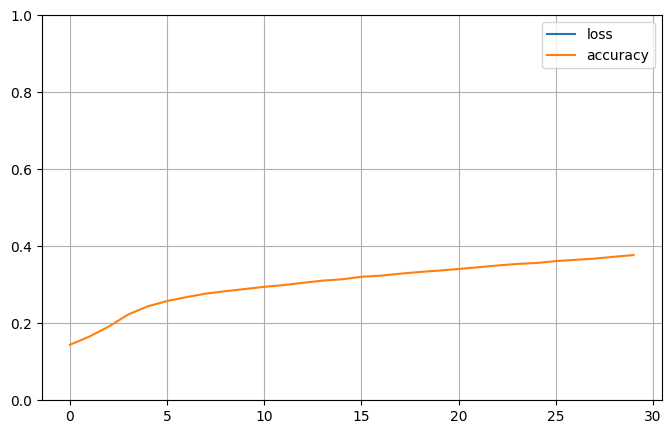

In [22]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [23]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.7641 - accuracy: 0.3856
test loss, test acc: [1.764115571975708, 0.3856250047683716]


In [24]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[2 1 1 ... 7 7 7]
2
[[1033 2202 1114 1470 1188  621  979 1393]
 [  76 7157  455  411  407  238  737  519]
 [ 217 1696 2743 1460  803  559 1402 1120]
 [ 160 1089  915 5657  672  367  661  479]
 [ 436 1766  995 1512 2153  593 1109 1436]
 [ 348 1655 1543 1737 1133 1349  989 1246]
 [ 115 1816 1116 1001  789  360 4177  626]
 [ 225  899  753  475  279  344  444 6581]]
              precision    recall  f1-score   support

           0       0.40      0.10      0.16     10000
           1       0.39      0.72      0.51     10000
           2       0.28      0.27      0.28     10000
           3       0.41      0.57      0.48     10000
           4       0.29      0.22      0.25     10000
           5       0.30      0.13      0.19     10000
           6       0.40      0.42      0.41     10000
           7       0.49      0.66      0.56     10000

    accuracy                           0.39     80000
   macro avg       0.37      0.39   

Test Accuracy:0.385625


Text(0.5, 1.0, 'Accuracy:0.386')

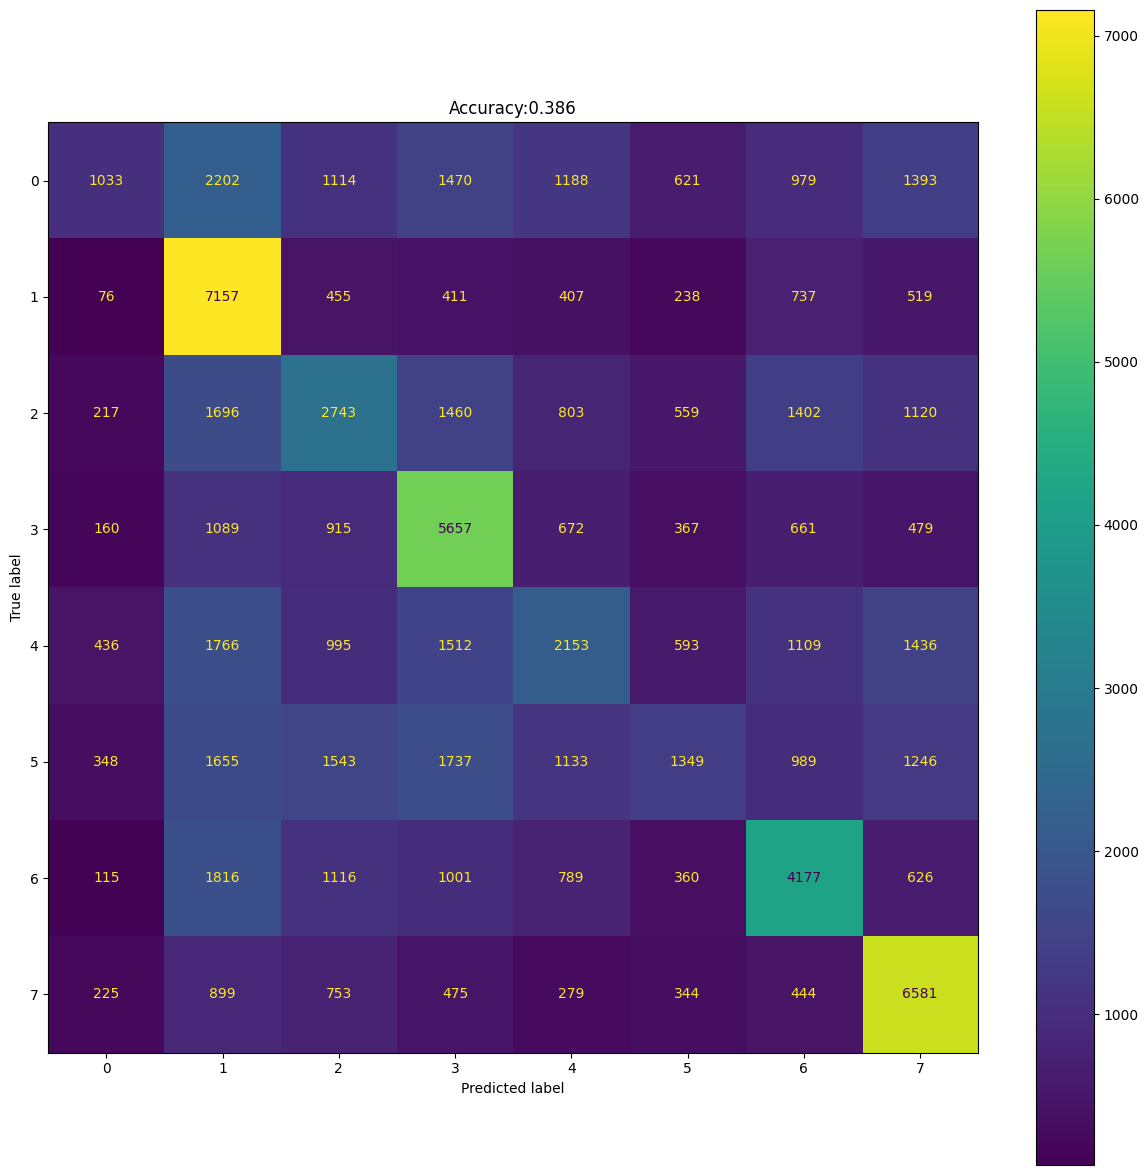

In [25]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iii) model to Nordic Device-25(v) dataset 

In [26]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")

In [27]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.1948 - accuracy: 0.7174
test loss, test acc: [1.1948213577270508, 0.7173749804496765]


In [28]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[6 4 3 ... 7 7 7]
6
[[6506   20  623  101  101 2253  383   13]
 [   1 9936   19    3    0   26   14    1]
 [ 201  237 5664  119   70 1969 1689   51]
 [   2    6   29 9800   15   95   27   26]
 [5597    4  342   79 1034 2742  202    0]
 [ 464   90 1227  255  243 6974  637  110]
 [  14  226 1389    5   26  445 7860   35]
 [   0   12   71   15   11  241   34 9616]]
              precision    recall  f1-score   support

           0       0.51      0.65      0.57     10000
           1       0.94      0.99      0.97     10000
           2       0.60      0.57      0.59     10000
           3       0.94      0.98      0.96     10000
           4       0.69      0.10      0.18     10000
           5       0.47      0.70      0.56     10000
           6       0.72      0.79      0.75     10000
           7       0.98      0.96      0.97     10000

    accuracy                           0.72     80000
   macro avg       0.73      0.72  

Test Accuracy:0.717375


Text(0.5, 1.0, 'Accuracy:0.717')

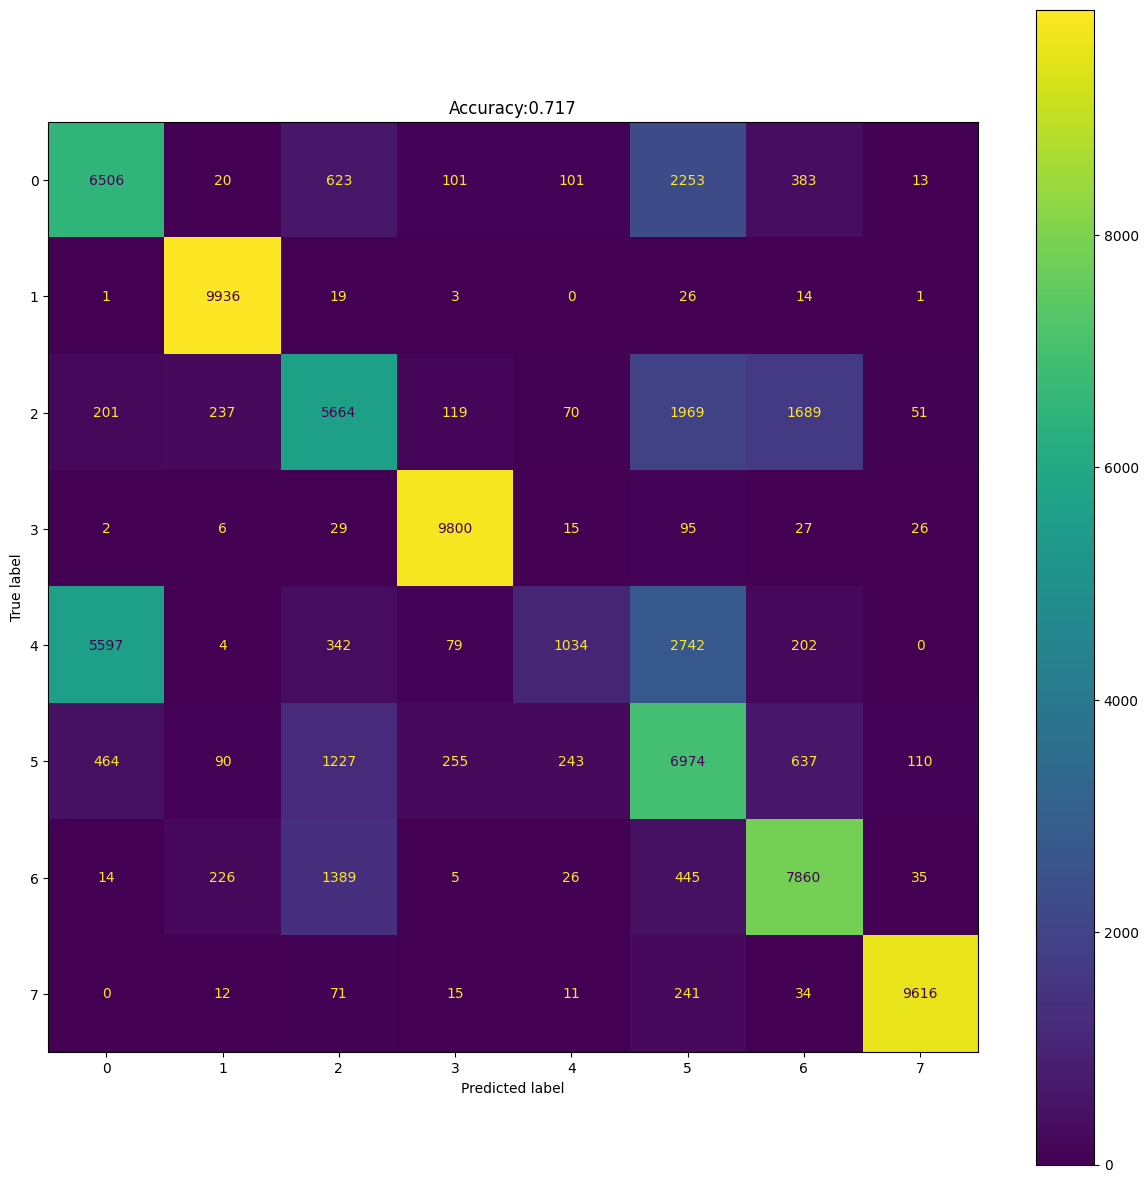

In [29]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [30]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [31]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [32]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.8168 - accuracy: 0.7439
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6725 - accuracy: 0.7645
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.6091 - accuracy: 0.7755
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5762 - accuracy: 0.7816
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5580 - accuracy: 0.7870
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5468 - accuracy: 0.7906
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5391 - accuracy: 0.7925
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5335 - accuracy: 0.7949
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5293 - accuracy: 0.7965
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5

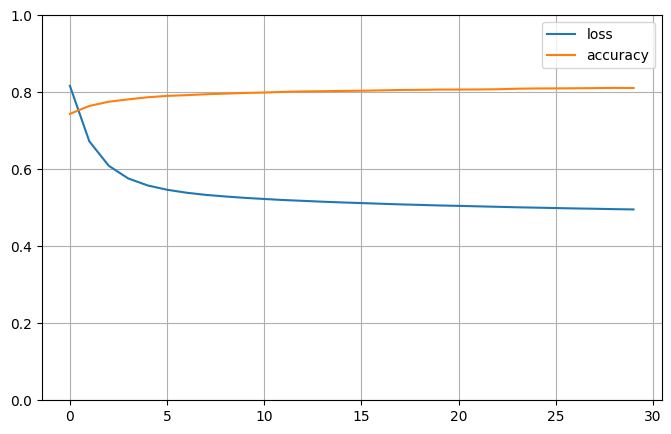

In [33]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [34]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.4950 - accuracy: 0.8115
test loss, test acc: [0.49499762058258057, 0.8114874958992004]


In [35]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[0 4 5 ... 7 7 7]
0
[[6353    0  271   18 2372  903   68   15]
 [   4 9937   28    2    3   18    7    1]
 [ 165   13 6761   21  124 1468 1428   20]
 [  10    0   26 9819   14  108    8   15]
 [2560    0  158   10 6469  778   24    1]
 [ 627    4 1228   74  811 6937  241   78]
 [  12    2  875    1   36  172 8893    9]
 [  23    0   75    6    2  120   24 9750]]
              precision    recall  f1-score   support

           0       0.65      0.64      0.64     10000
           1       1.00      0.99      1.00     10000
           2       0.72      0.68      0.70     10000
           3       0.99      0.98      0.98     10000
           4       0.66      0.65      0.65     10000
           5       0.66      0.69      0.68     10000
           6       0.83      0.89      0.86     10000
           7       0.99      0.97      0.98     10000

    accuracy                           0.81     80000
   macro avg       0.81      0.81   

Test Accuracy:0.8114875


Text(0.5, 1.0, 'Accuracy:0.811')

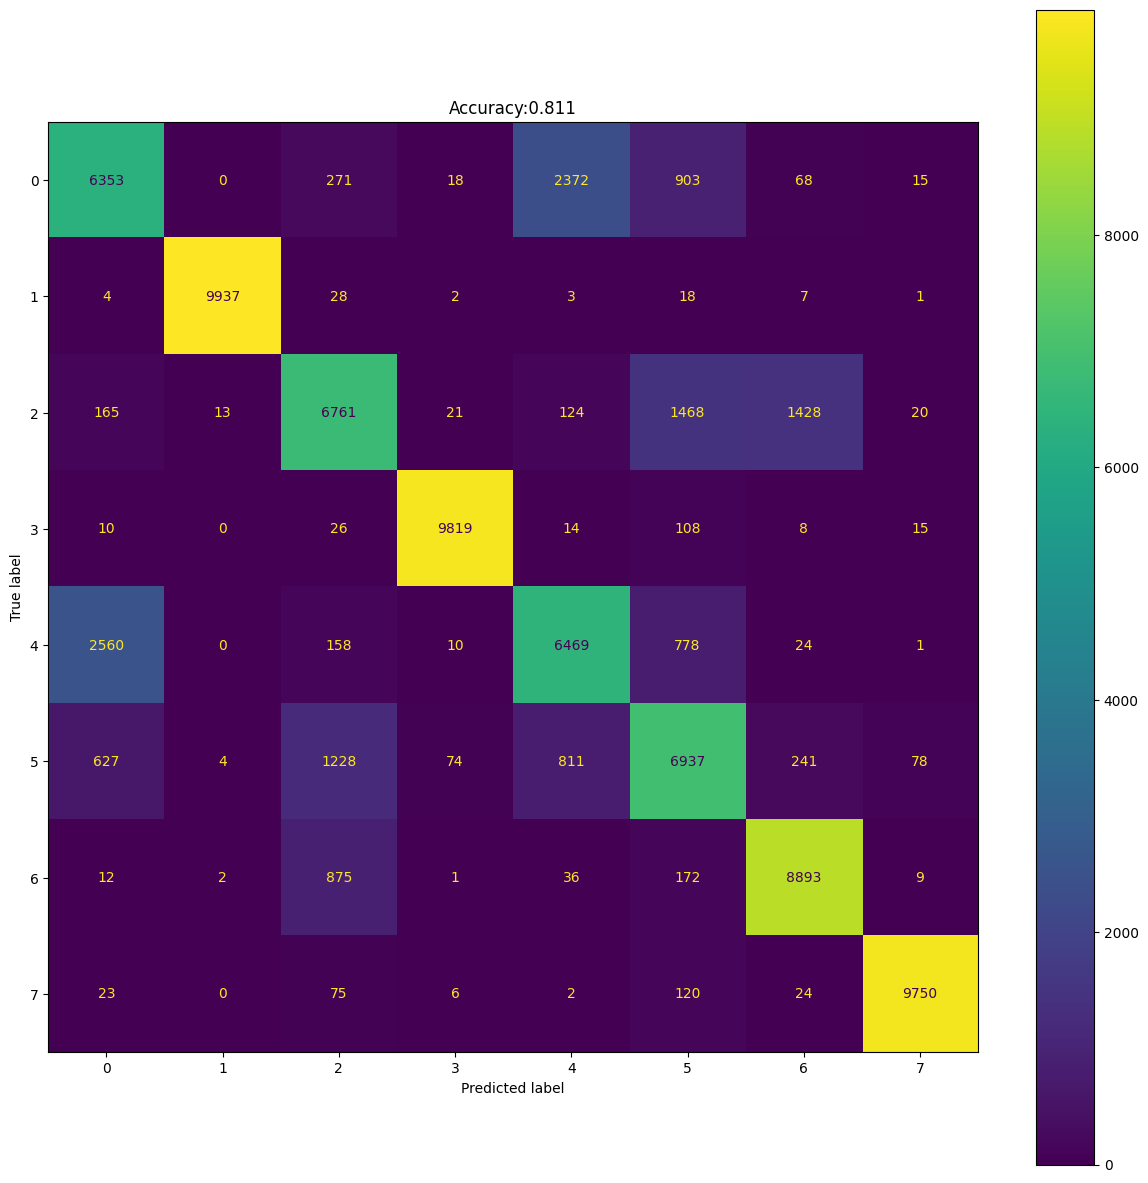

In [36]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-25(iv) model to Nordic Device-25(v) dataset 

In [37]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")

In [38]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.9026 - accuracy: 0.7262
test loss, test acc: [0.902612030506134, 0.7262125015258789]


In [39]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 9s 4ms/step
[6 5 5 ... 7 7 7]
6
[[3710    1  139   49 3938 1661  426   76]
 [   4 9935   14    4    1   18   11   13]
 [ 319  205 5443   84  145 1265 2459   80]
 [  58    0  131 9090   43  590   68   20]
 [3208    1   35   25 5689  881  137   24]
 [1148   18  731  154  529 6721  493  206]
 [  59  177  706    6   27  332 8684    9]
 [  97    4   87   21  131  630  205 8825]]
              precision    recall  f1-score   support

           0       0.43      0.37      0.40     10000
           1       0.96      0.99      0.98     10000
           2       0.75      0.54      0.63     10000
           3       0.96      0.91      0.94     10000
           4       0.54      0.57      0.55     10000
           5       0.56      0.67      0.61     10000
           6       0.70      0.87      0.77     10000
           7       0.95      0.88      0.92     10000

    accuracy                           0.73     80000
   macro avg       0.73      0.73   

Test Accuracy:0.7262125


Text(0.5, 1.0, 'Accuracy:0.726')

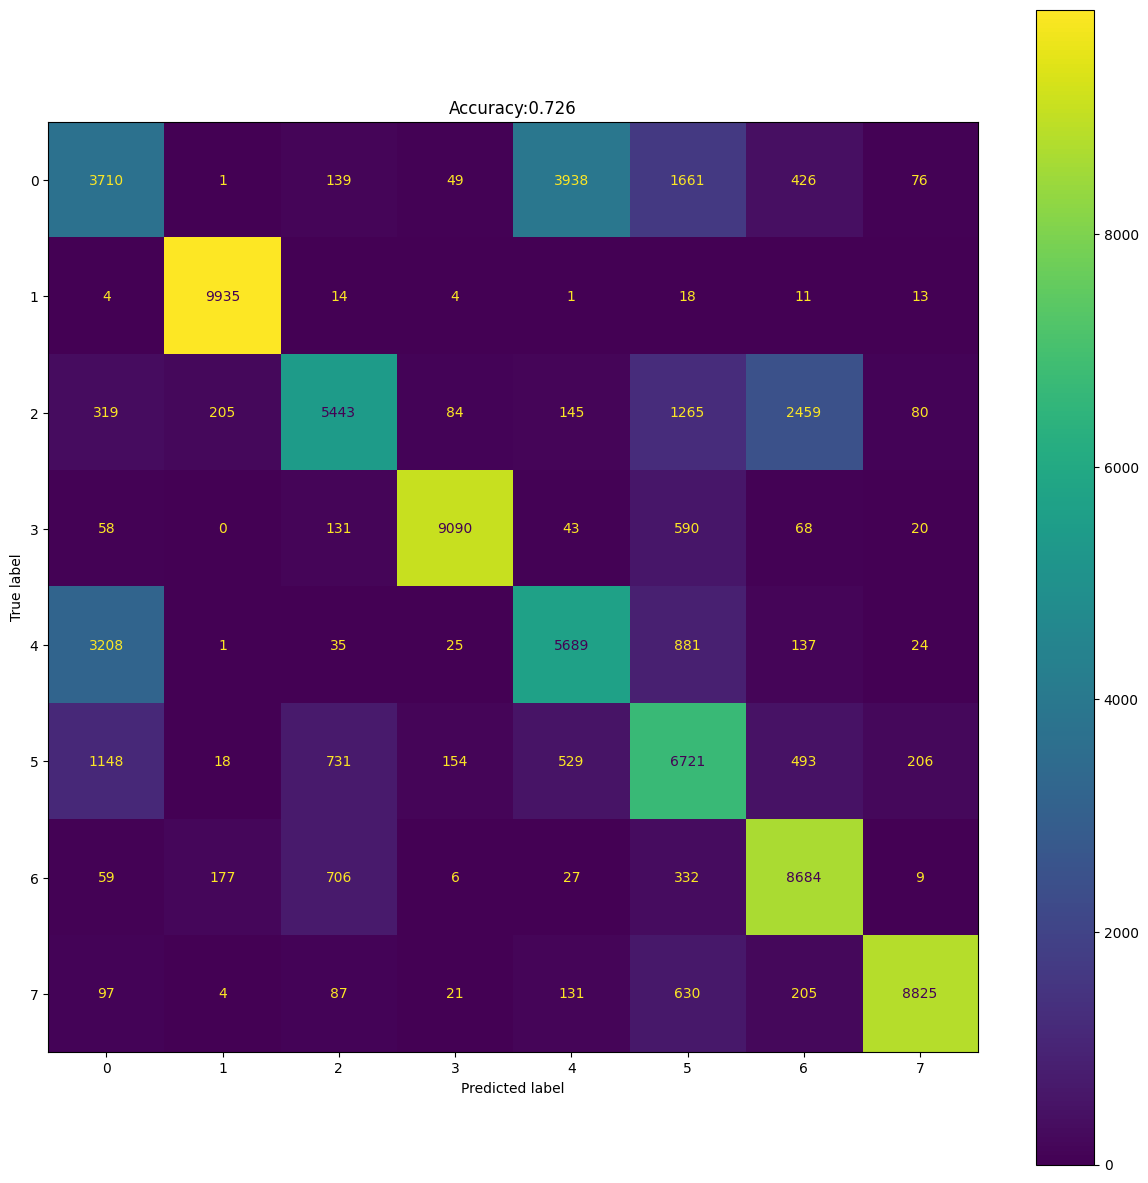

In [40]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning

Nordic Device-25(iv) model to Nordic Device-25(v) dataset 

In [41]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-25/Nordic-device-25-Own_models/Nordic-25(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [42]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [43]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.7830 - accuracy: 0.7440
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 0.6675 - accuracy: 0.7576
Epoch 3/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.6053 - accuracy: 0.7687
Epoch 4/30
2500/2500 [==============================] - 12s 5ms/step - loss: 0.5744 - accuracy: 0.7752
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 0.5586 - accuracy: 0.7806
Epoch 6/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5500 - accuracy: 0.7850
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5447 - accuracy: 0.7882
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5409 - accuracy: 0.7898
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 0.5385 - accuracy: 0.7912
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - loss:

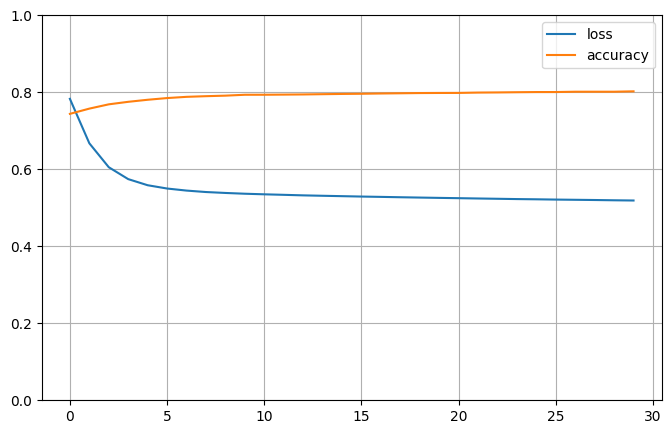

In [44]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [45]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 0.5180 - accuracy: 0.8028
test loss, test acc: [0.5179967284202576, 0.8028249740600586]


In [46]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 7 7 7]
5
[[4376    0  248   35 3826 1369   81   65]
 [   0 9929   34    5    1   16    8    7]
 [ 152   10 7802   34    4  843 1130   25]
 [  41    0   52 9676   12  174   27   18]
 [2324    1   47   10 7152  430   13   23]
 [1058    2  836  147  234 7419  169  135]
 [  52    6 1230   13   27  171 8476   25]
 [ 140    0  129   17   25  236   57 9396]]
              precision    recall  f1-score   support

           0       0.54      0.44      0.48     10000
           1       1.00      0.99      1.00     10000
           2       0.75      0.78      0.77     10000
           3       0.97      0.97      0.97     10000
           4       0.63      0.72      0.67     10000
           5       0.70      0.74      0.72     10000
           6       0.85      0.85      0.85     10000
           7       0.97      0.94      0.95     10000

    accuracy                           0.80     80000
   macro avg       0.80      0.80  

Test Accuracy:0.802825


Text(0.5, 1.0, 'Accuracy:0.803')

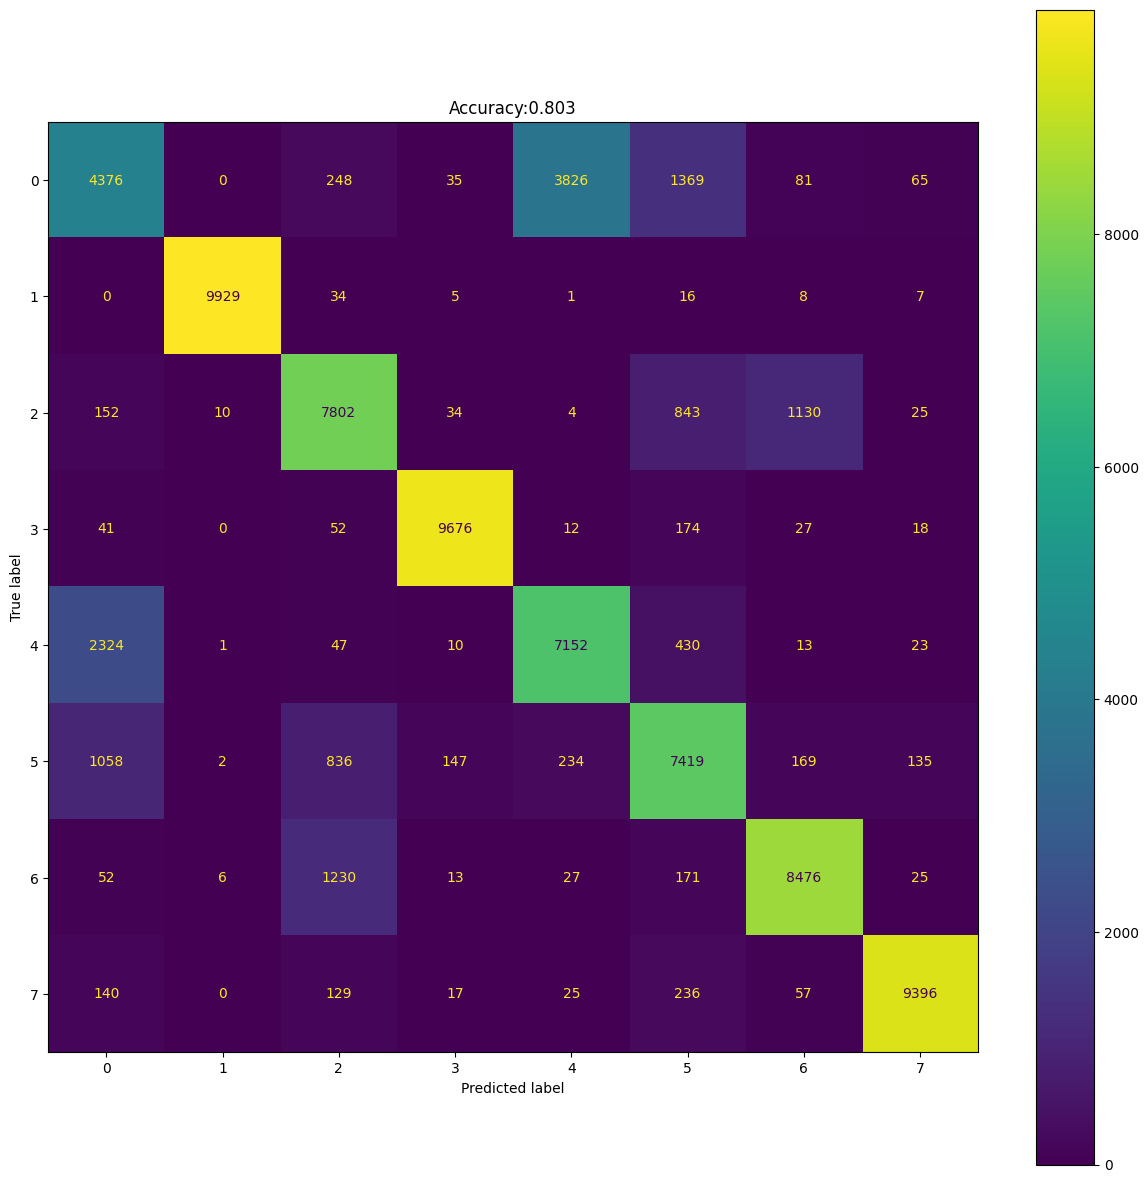

In [47]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation applying the Model of other Device samples

Nordic Device-30(i) model to Nordic Device-25(v) dataset 

In [48]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")

In [49]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 6.5560 - accuracy: 0.1245
test loss, test acc: [6.555963516235352, 0.1244874969124794]


In [50]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[2 2 2 ... 2 2 2]
2
[[   0    0 8257    8    0 1185  550    0]
 [   0    1 9276   46    0  490  181    6]
 [   0    0 8604    2    0  467  924    3]
 [   0    0 8072    1    0  534 1393    0]
 [   0    0 7948    1    0  935 1116    0]
 [   0    0 7963    2    0  690 1345    0]
 [   0    0 8889   30    0  413  656   12]
 [   0    0 7899    7    0  372 1715    7]]
              precision    recall  f1-score   support

           0       0.00      0.00      0.00     10000
           1       1.00      0.00      0.00     10000
           2       0.13      0.86      0.22     10000
           3       0.01      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.14      0.07      0.09     10000
           6       0.08      0.07      0.07     10000
           7       0.25      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.20      0.12  

Test Accuracy:0.1244875


Text(0.5, 1.0, 'Accuracy:0.124')

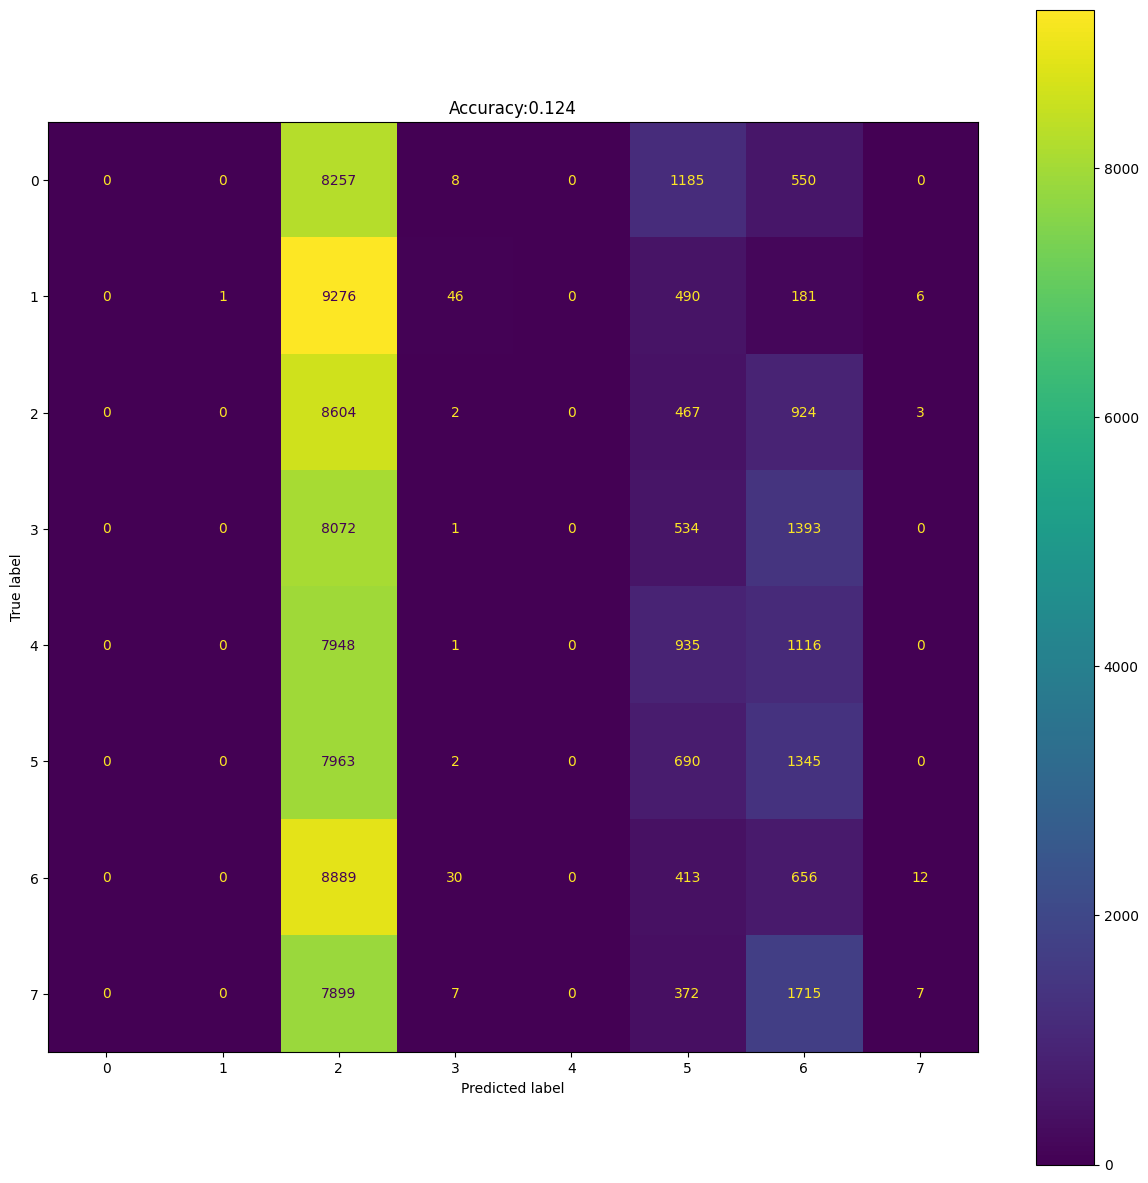

In [51]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [52]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(i)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [53]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [54]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 12s 4ms/step - loss: 2.5995 - accuracy: 0.1921
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0951 - accuracy: 0.2297
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.9375 - accuracy: 0.2537
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8750 - accuracy: 0.2735
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8412 - accuracy: 0.2903
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8178 - accuracy: 0.3055
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7988 - accuracy: 0.3191
Epoch 8/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7831 - accuracy: 0.3289
Epoch 9/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7690 - accuracy: 0.3388
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss

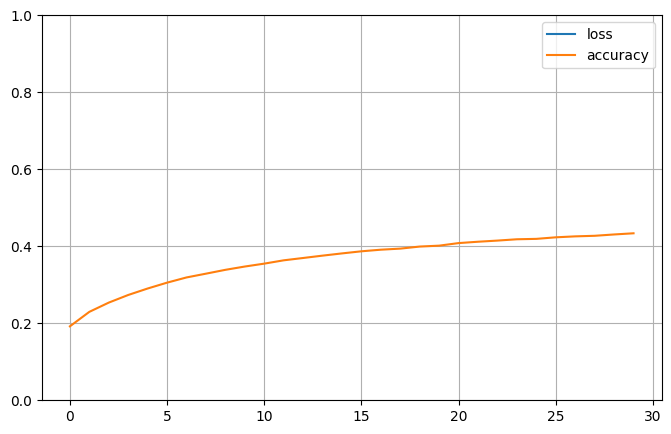

In [55]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [56]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.5977 - accuracy: 0.4422
test loss, test acc: [1.597667932510376, 0.4421750009059906]


In [57]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 0 0 ... 7 5 7]
3
[[2802 1041 1272  823 1434 1205  863  560]
 [ 450 6830  585  187  243  199 1173  333]
 [ 682  938 3162 1020  801  884 1720  793]
 [ 522  315  769 5108  567  786 1260  673]
 [1242  531 1302 1048 2747 1366  998  766]
 [ 875  468 1293 1468 1260 2540 1057 1039]
 [ 367 1316  651  584  356  352 5837  537]
 [ 388  358  566  582  258  632  868 6348]]
              precision    recall  f1-score   support

           0       0.38      0.28      0.32     10000
           1       0.58      0.68      0.63     10000
           2       0.33      0.32      0.32     10000
           3       0.47      0.51      0.49     10000
           4       0.36      0.27      0.31     10000
           5       0.32      0.25      0.28     10000
           6       0.42      0.58      0.49     10000
           7       0.57      0.63      0.60     10000

    accuracy                           0.44     80000
   macro avg       0.43      0.44  

Test Accuracy:0.442175


Text(0.5, 1.0, 'Accuracy:0.442')

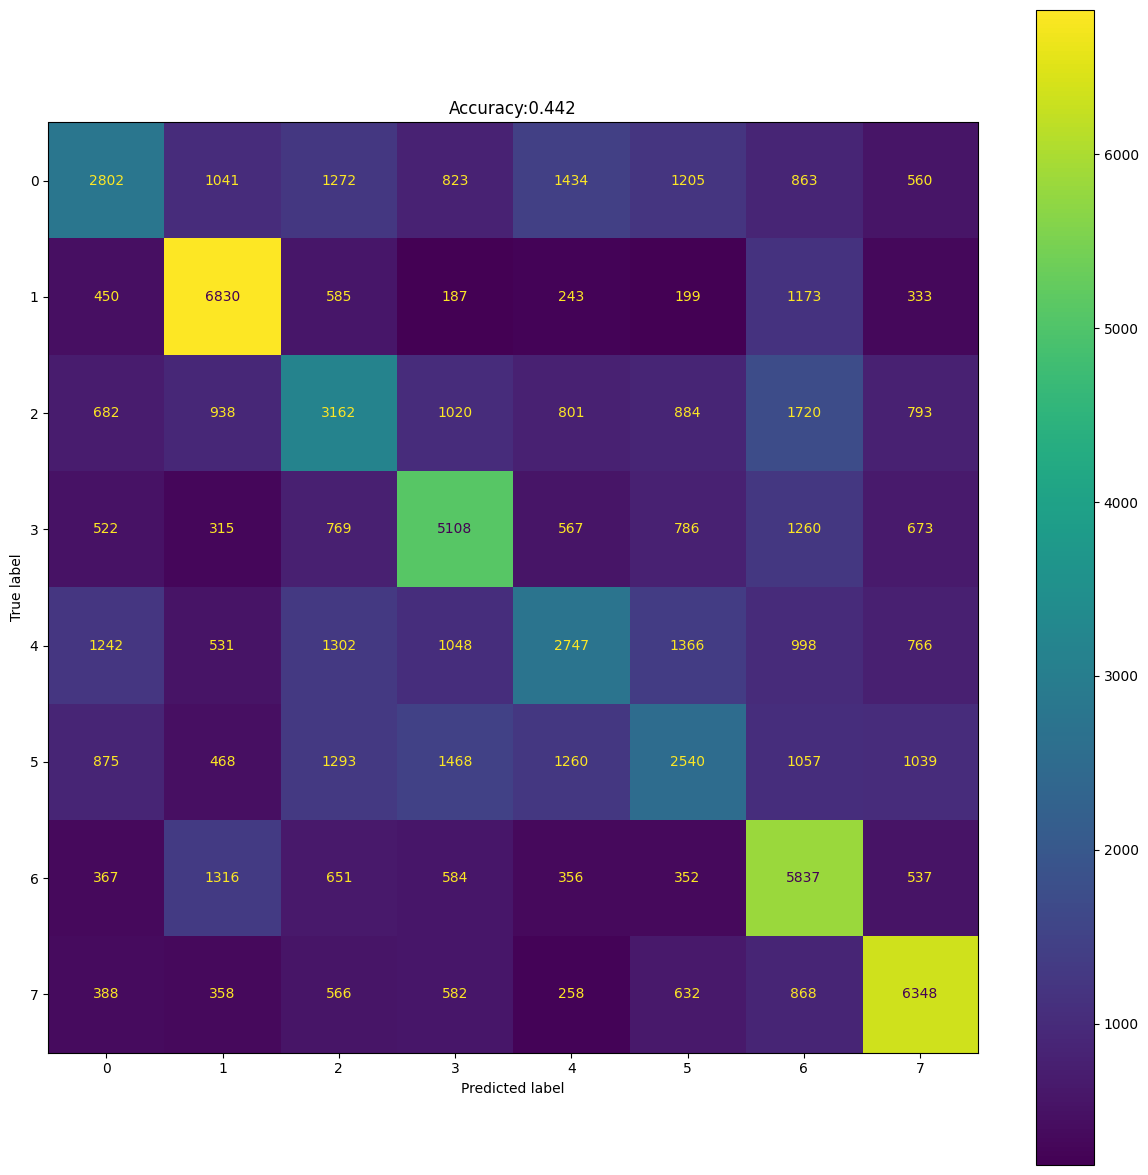

In [58]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(ii) model to Nordic Device-25(v) dataset 

In [59]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")

In [60]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 8.3786 - accuracy: 0.1280
test loss, test acc: [8.378555297851562, 0.12802499532699585]


In [61]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 6 5 2]
5
[[  29    0 2811    0    0 6775  383    2]
 [   1   39 1143   14    0 8620  181    2]
 [  10    4 3029    3    0 6300  648    6]
 [   8    0 2257    0    0 7292  440    3]
 [  22    0 1736    1    0 7626  615    0]
 [  14    0 2917    2    0 6555  512    0]
 [   6   16 2778    3    0 6608  571   18]
 [  19    1 2622    1    0 5457 1881   19]]
              precision    recall  f1-score   support

           0       0.27      0.00      0.01     10000
           1       0.65      0.00      0.01     10000
           2       0.16      0.30      0.21     10000
           3       0.00      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.12      0.66      0.20     10000
           6       0.11      0.06      0.07     10000
           7       0.38      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.21      0.13  

Test Accuracy:0.128025


Text(0.5, 1.0, 'Accuracy:0.128')

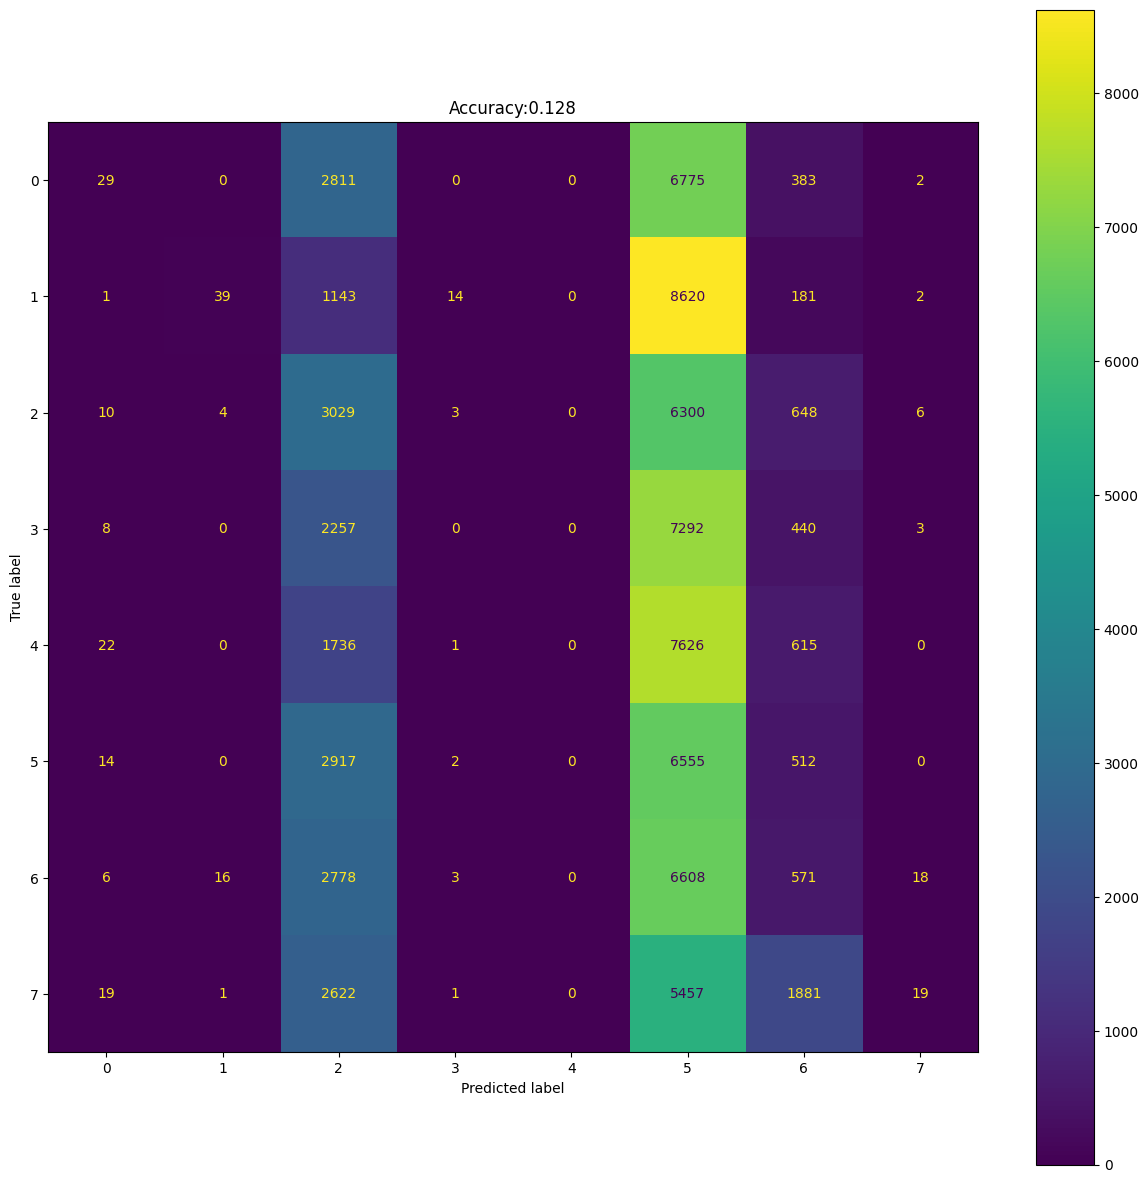

In [62]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [63]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(ii)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [64]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [65]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.8064 - accuracy: 0.1846
Epoch 2/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.0477 - accuracy: 0.2269
Epoch 3/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.9029 - accuracy: 0.2639
Epoch 4/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8439 - accuracy: 0.2913
Epoch 5/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.8096 - accuracy: 0.3083
Epoch 6/30
2500/2500 [==============================] - 9s 3ms/step - loss: 1.7855 - accuracy: 0.3205
Epoch 7/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1.7659 - accuracy: 0.3316
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7496 - accuracy: 0.3394
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7349 - accuracy: 0.3451
Epoch 10/30
2500/2500 [==============================] - 9s 4ms/step - loss: 1

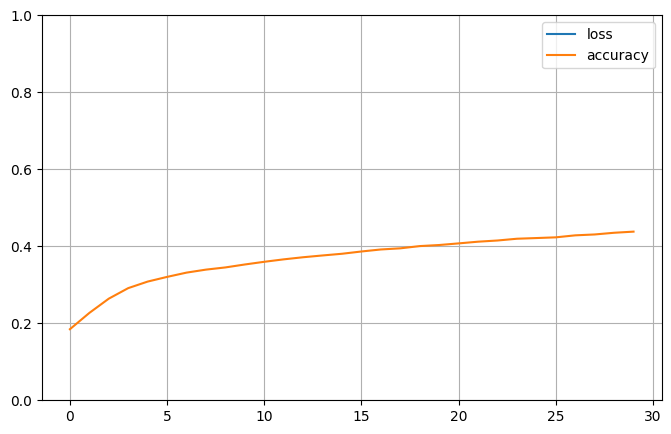

In [66]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [67]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.5643 - accuracy: 0.4399
test loss, test acc: [1.5643351078033447, 0.43985000252723694]


In [68]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 4 6 ... 7 7 7]
3
[[3107  620  186  977 1953 1037 1412  708]
 [ 265 8158   84   44  325  231  867   26]
 [1113  938  780 1025 1351 1245 2734  814]
 [ 696  202  111 5549  960  338 1487  657]
 [1614  632  142 1179 3368  905 1291  869]
 [1551  758  298  905 1920 2120 1619  829]
 [ 735  966  112 1135  918  411 5159  564]
 [ 552  114   74  519  679  401  714 6947]]
              precision    recall  f1-score   support

           0       0.32      0.31      0.32     10000
           1       0.66      0.82      0.73     10000
           2       0.44      0.08      0.13     10000
           3       0.49      0.55      0.52     10000
           4       0.29      0.34      0.31     10000
           5       0.32      0.21      0.25     10000
           6       0.34      0.52      0.41     10000
           7       0.61      0.69      0.65     10000

    accuracy                           0.44     80000
   macro avg       0.43      0.44  

Test Accuracy:0.43985


Text(0.5, 1.0, 'Accuracy:0.440')

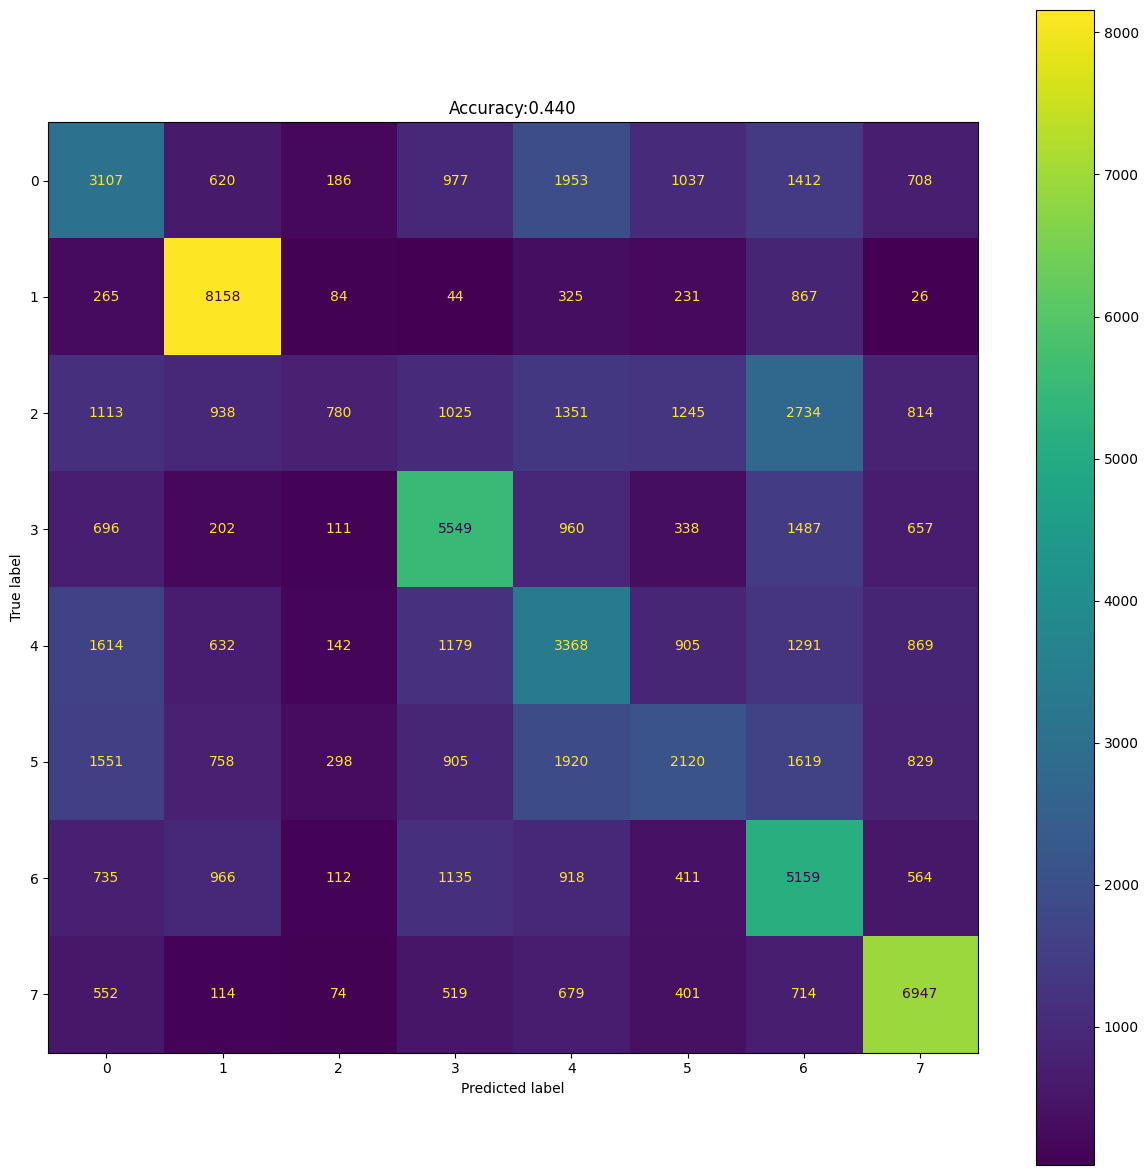

In [69]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iii) model to Nordic Device-25(v) dataset 

In [70]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")

In [71]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 4.8220 - accuracy: 0.1308
test loss, test acc: [4.822019100189209, 0.1308249980211258]


In [72]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 2 ... 5 4 5]
5
[[   9   10 3949  345  569 4709  204  205]
 [   1  203 3249   76  955 5153  341   22]
 [   7   21 4099  263  860 4316  274  160]
 [   3   29 2327  111 1660 5607   66  197]
 [  11   10 3075  280  925 5191  266  242]
 [  17   13 3638  235 1031 4709  130  227]
 [   4   14 4787  157 2401 2056  357  224]
 [  22  132 3548  193 2485 3128  439   53]]
              precision    recall  f1-score   support

           0       0.12      0.00      0.00     10000
           1       0.47      0.02      0.04     10000
           2       0.14      0.41      0.21     10000
           3       0.07      0.01      0.02     10000
           4       0.08      0.09      0.09     10000
           5       0.14      0.47      0.21     10000
           6       0.17      0.04      0.06     10000
           7       0.04      0.01      0.01     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13  

Test Accuracy:0.130825


Text(0.5, 1.0, 'Accuracy:0.131')

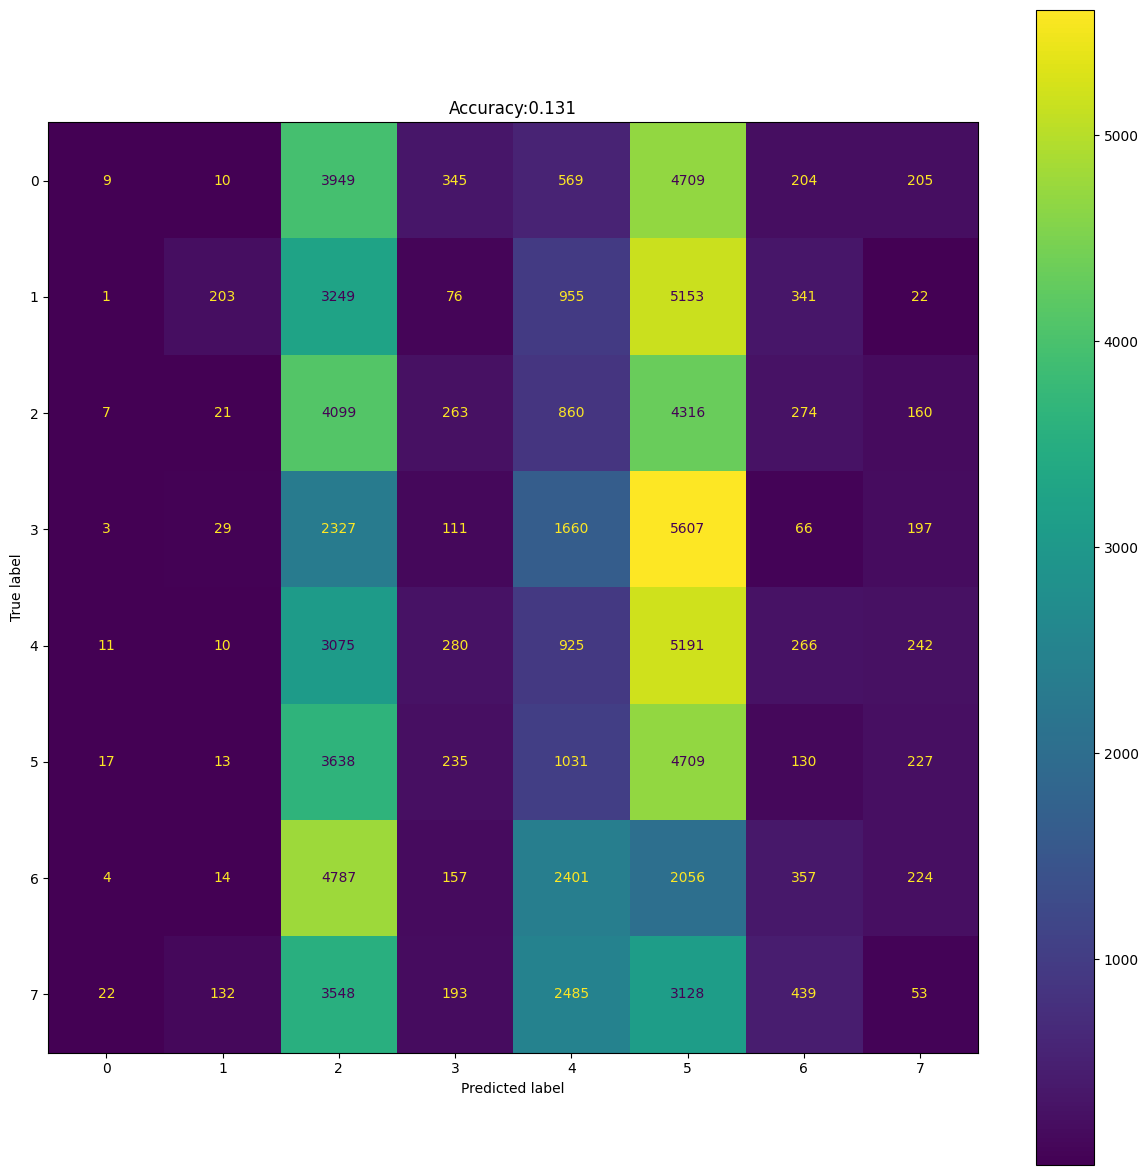

In [73]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [74]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iii)_model.h5")
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
Non-

In [75]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 1400)              2868600   
                                                                 
 dense_1 (Dense)             (None, 800)               1120800   
                                                                 
 dense_2 (Dense)             (None, 500)               400500    
                                                                 
 dense_3 (Dense)             (None, 200)               100200    
                                                                 
 dense_4 (Dense)             (None, 100)               20100     
                                                                 
 dense_5 (Dense)             (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-traina

In [76]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 11s 4ms/step - loss: 2.9469 - accuracy: 0.1610
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.1155 - accuracy: 0.2225
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8709 - accuracy: 0.2866
Epoch 4/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7982 - accuracy: 0.3197
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7661 - accuracy: 0.3356
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7460 - accuracy: 0.3458
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7307 - accuracy: 0.3546
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7182 - accuracy: 0.3603
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7071 - accuracy: 0.3670
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

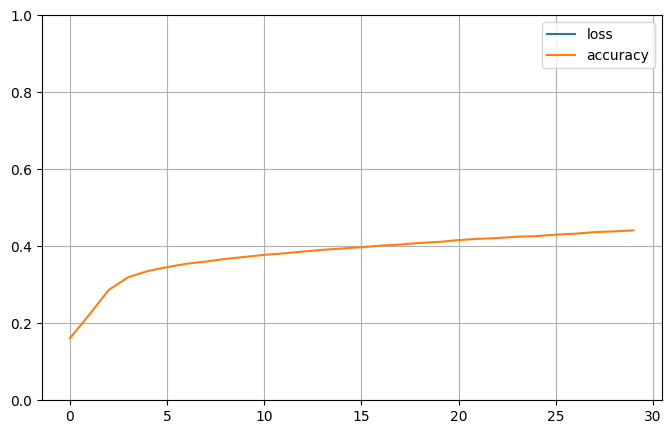

In [77]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [78]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 1.5644 - accuracy: 0.4438
test loss, test acc: [1.5643723011016846, 0.4438124895095825]


In [79]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[3 4 3 ... 7 7 7]
3
[[3606  717  645 1309 1611  470  745  897]
 [ 463 6804  333  705  277  128  606  684]
 [1309  978 2182 1710 1027  513 1241 1040]
 [ 660  683  373 5825  690  233  793  743]
 [1673  520  469 1571 3324  496  991  956]
 [1599  640  695 2027 1546 1285  936 1272]
 [ 488  772  630 1087  637  314 5312  760]
 [ 537  472  289  527  341  247  420 7167]]
              precision    recall  f1-score   support

           0       0.35      0.36      0.35     10000
           1       0.59      0.68      0.63     10000
           2       0.39      0.22      0.28     10000
           3       0.39      0.58      0.47     10000
           4       0.35      0.33      0.34     10000
           5       0.35      0.13      0.19     10000
           6       0.48      0.53      0.50     10000
           7       0.53      0.72      0.61     10000

    accuracy                           0.44     80000
   macro avg       0.43      0.44  

Test Accuracy:0.4438125


Text(0.5, 1.0, 'Accuracy:0.444')

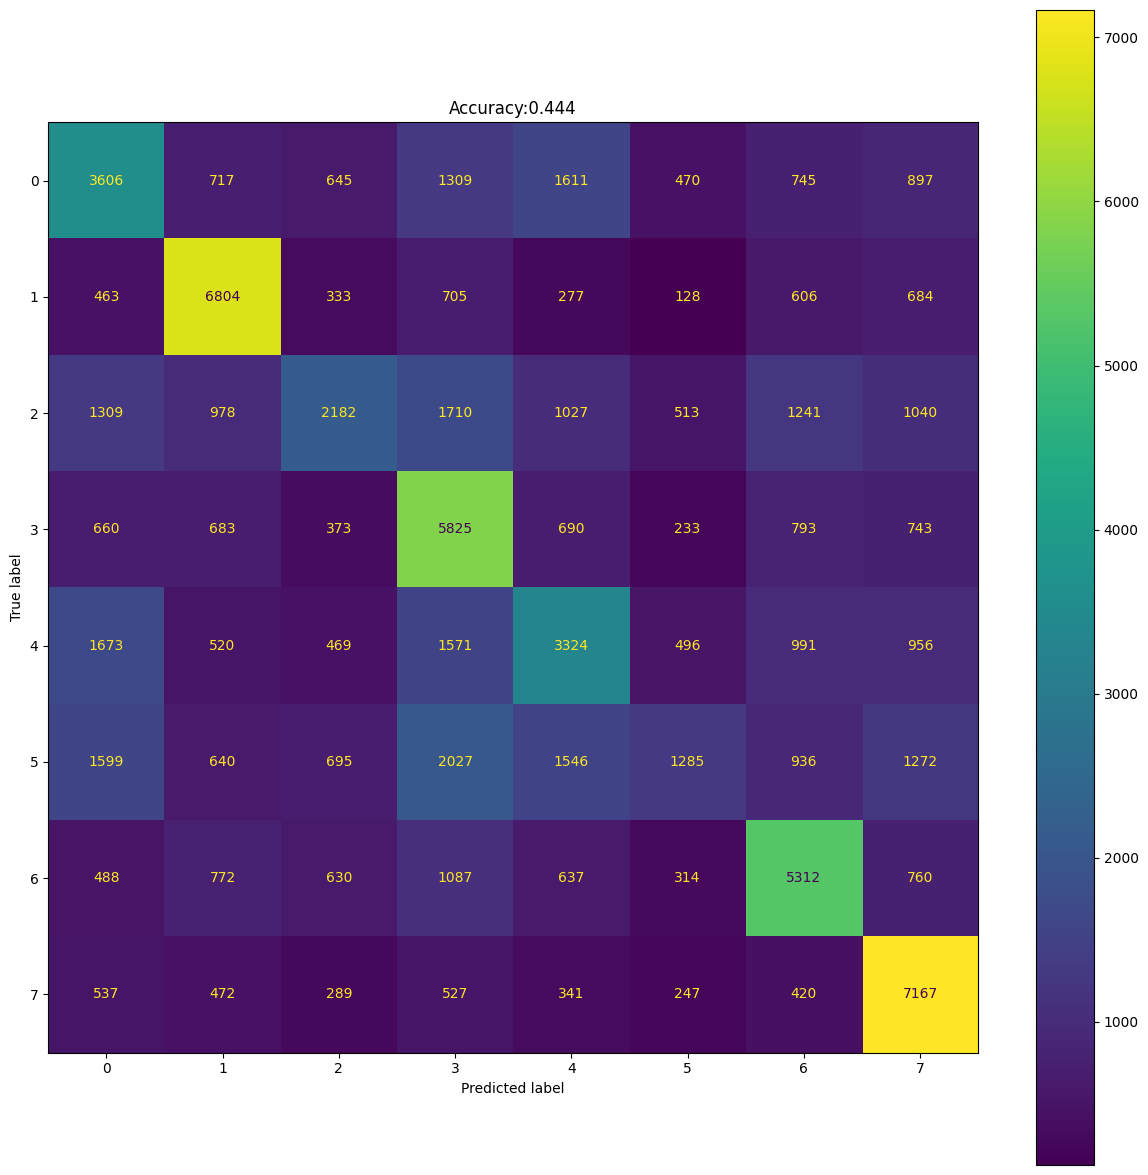

In [80]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(iv) model to Nordic Device-25(v) dataset 

In [81]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")

In [82]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 6.9198 - accuracy: 0.1192
test loss, test acc: [6.919829845428467, 0.1192374974489212]


In [83]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[5 5 5 ... 0 5 5]
5
[[ 363    0  132   33    0 9458   14    0]
 [1731    0 1004   12    0 7236   17    0]
 [ 530    0  352   19    0 9076   23    0]
 [1391    0  495    2    0 8100   12    0]
 [ 358    0  260   35    0 9317   30    0]
 [ 790    0  387   24    0 8780   19    0]
 [ 918    0  319    3    0 8718   42    0]
 [1366    0  933   47    0 7564   90    0]]
              precision    recall  f1-score   support

           0       0.05      0.04      0.04     10000
           1       0.00      0.00      0.00     10000
           2       0.09      0.04      0.05     10000
           3       0.01      0.00      0.00     10000
           4       0.00      0.00      0.00     10000
           5       0.13      0.88      0.22     10000
           6       0.17      0.00      0.01     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.12     80000
   macro avg       0.06      0.12  

Test Accuracy:0.1192375


Text(0.5, 1.0, 'Accuracy:0.119')

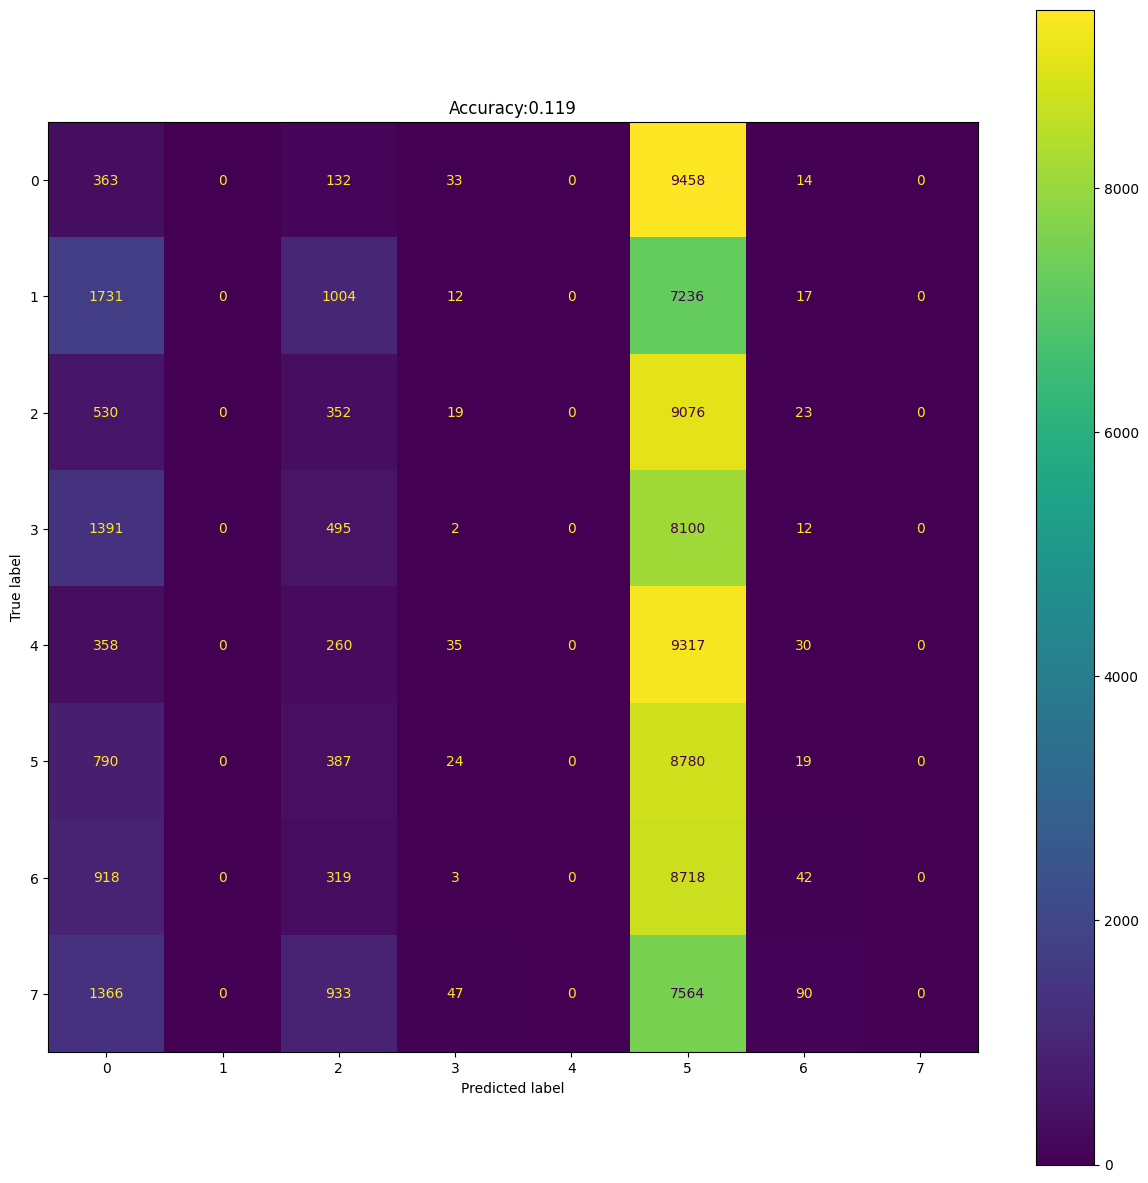

In [84]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [85]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(iv)_model.h5")
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [86]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 1400)              2868600   
                                                                 
 dense_7 (Dense)             (None, 800)               1120800   
                                                                 
 dense_8 (Dense)             (None, 500)               400500    
                                                                 
 dense_9 (Dense)             (None, 200)               100200    
                                                                 
 dense_10 (Dense)            (None, 100)               20100     
                                                                 
 dense_11 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [87]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 13s 5ms/step - loss: 3.0498 - accuracy: 0.1197
Epoch 2/30
2500/2500 [==============================] - 11s 5ms/step - loss: 2.1149 - accuracy: 0.1956
Epoch 3/30
2500/2500 [==============================] - 11s 5ms/step - loss: 1.9430 - accuracy: 0.2475
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8881 - accuracy: 0.2716
Epoch 5/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8571 - accuracy: 0.2866
Epoch 6/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8346 - accuracy: 0.2992
Epoch 7/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.8158 - accuracy: 0.3090
Epoch 8/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7994 - accuracy: 0.3194
Epoch 9/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.7848 - accuracy: 0.3270
Epoch 10/30
2500/2500 [==============================] - 11s 4ms/step - l

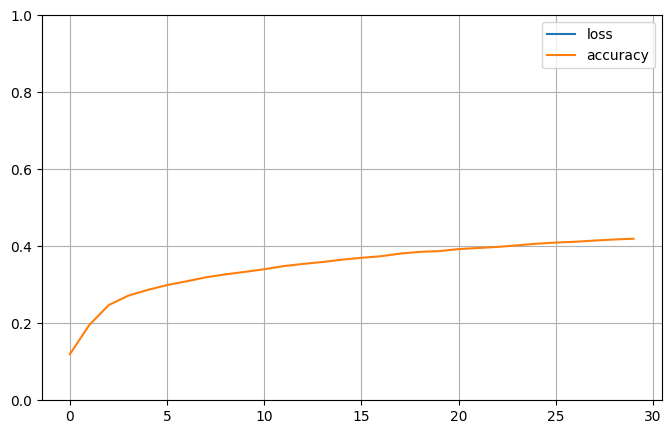

In [88]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [89]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.6102 - accuracy: 0.4196
test loss, test acc: [1.6101630926132202, 0.4195750057697296]


In [90]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 0 3 ... 7 6 3]
1
[[5504  433  379  852  750  765  827  490]
 [ 479 7666  124  522  139  156  488  426]
 [2831  853 1223 1752  692 1241  784  624]
 [ 921  828  219 5838  302  575  676  641]
 [3553  448  498 1419 1602 1259  749  472]
 [2400  609  529 2051  722 2072  912  705]
 [1448  674  179 1356  394  488 4687  774]
 [1105 1262  203  933  257  321  945 4974]]
              precision    recall  f1-score   support

           0       0.30      0.55      0.39     10000
           1       0.60      0.77      0.67     10000
           2       0.36      0.12      0.18     10000
           3       0.40      0.58      0.47     10000
           4       0.33      0.16      0.22     10000
           5       0.30      0.21      0.25     10000
           6       0.47      0.47      0.47     10000
           7       0.55      0.50      0.52     10000

    accuracy                           0.42     80000
   macro avg       0.41      0.42  

Test Accuracy:0.419575


Text(0.5, 1.0, 'Accuracy:0.420')

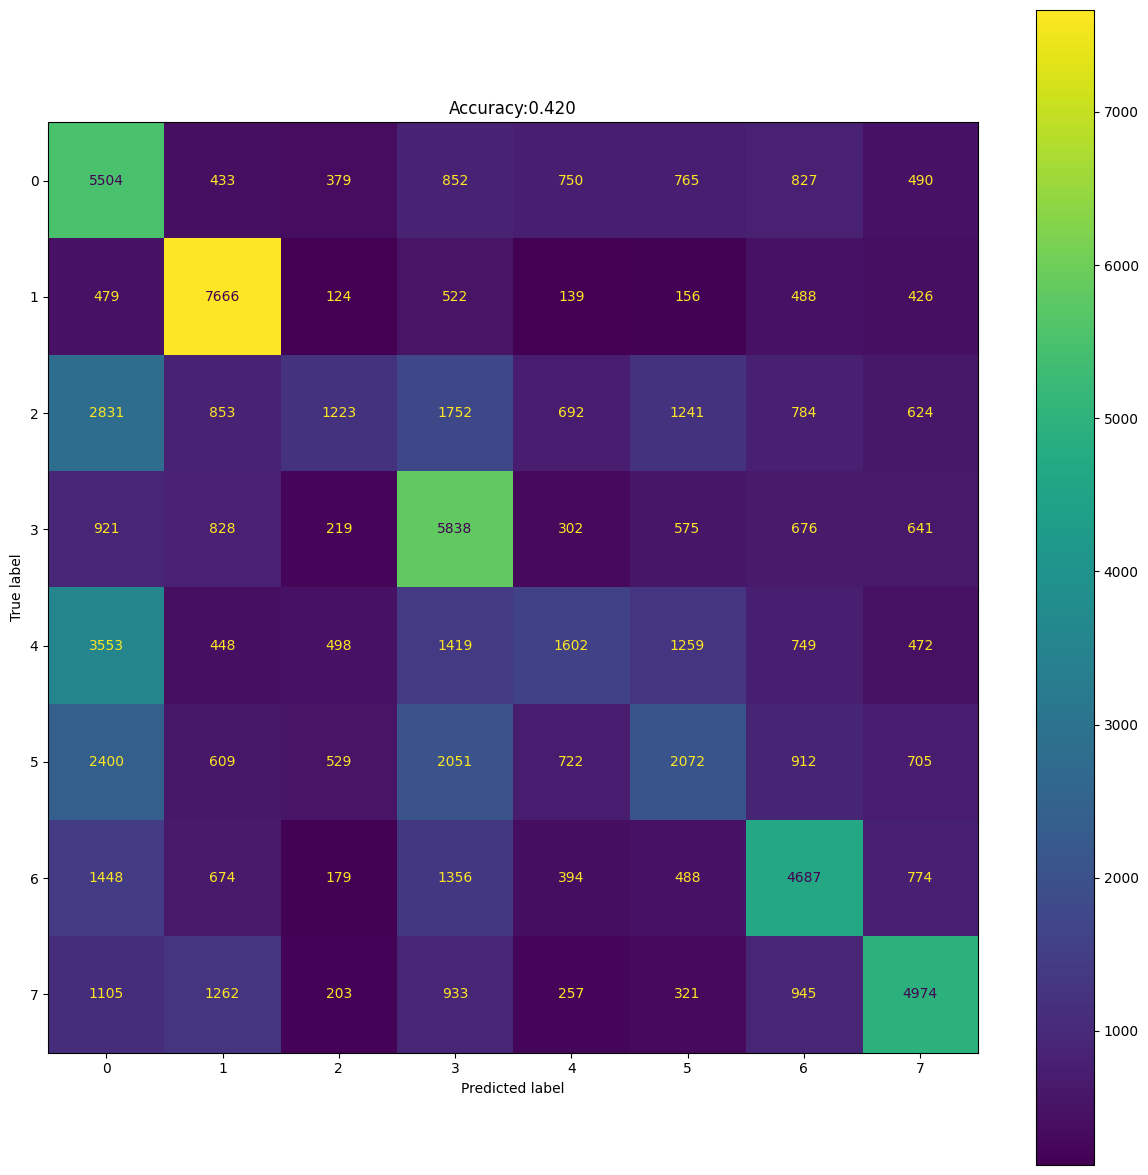

In [91]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

Nordic Device-30(v) model to Nordic Device-25(v) dataset 

In [92]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")

In [93]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 11s 4ms/step - loss: 5.8443 - accuracy: 0.1347
test loss, test acc: [5.844252109527588, 0.1347375065088272]


In [94]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[0 5 5 ... 5 0 5]
0
[[5412    1  180  201    0 4180   26    0]
 [5698    8  109   14    0 4099   72    0]
 [4171    0  204   59    0 5530   34    2]
 [3449    1  344   56    0 6138   10    2]
 [5007    1  228   69    0 4682    9    4]
 [4475    3  407   82    0 5020   11    2]
 [6763    3  659   17    0 2476   79    3]
 [5552    0  389   25    0 3987   47    0]]
              precision    recall  f1-score   support

           0       0.13      0.54      0.21     10000
           1       0.47      0.00      0.00     10000
           2       0.08      0.02      0.03     10000
           3       0.11      0.01      0.01     10000
           4       0.00      0.00      0.00     10000
           5       0.14      0.50      0.22     10000
           6       0.27      0.01      0.02     10000
           7       0.00      0.00      0.00     10000

    accuracy                           0.13     80000
   macro avg       0.15      0.13  

Test Accuracy:0.1347375


Text(0.5, 1.0, 'Accuracy:0.135')

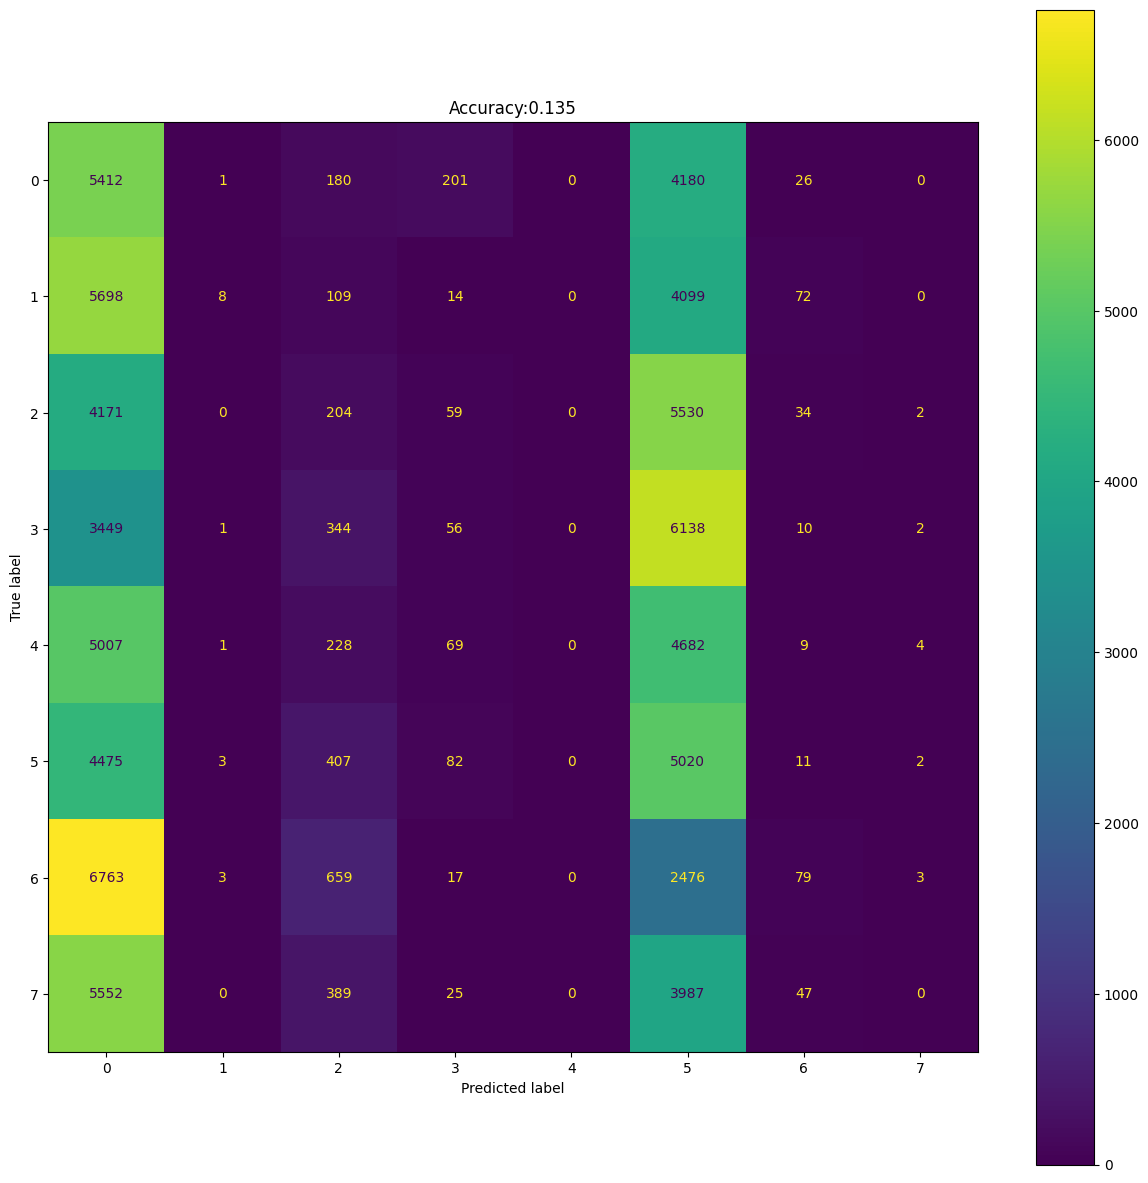

In [95]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')

## Cross-model Validation by applying Transfer Learning of other Device's Model

In [96]:
model = keras.models.load_model("/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/32MHz/Device-30/Nordic-device-30-Own_models/Nordic-30(v)_model.h5")
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 4,511,008
No

In [97]:
# Freeze all layers except the last one.
for layer in model.layers[:-1]:
  layer.trainable = False

model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_12 (Dense)            (None, 1400)              2868600   
                                                                 
 dense_13 (Dense)            (None, 800)               1120800   
                                                                 
 dense_14 (Dense)            (None, 500)               400500    
                                                                 
 dense_15 (Dense)            (None, 200)               100200    
                                                                 
 dense_16 (Dense)            (None, 100)               20100     
                                                                 
 dense_17 (Dense)            (None, 8)                 808       
                                                                 
Total params: 4,511,008
Trainable params: 808
Non-trai

In [98]:
opt = keras.optimizers.SGD(learning_rate=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=opt, metrics=["accuracy"])

history = model.fit(X, Y, epochs=30)

Epoch 1/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.8351 - accuracy: 0.1480
Epoch 2/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.2218 - accuracy: 0.1816
Epoch 3/30
2500/2500 [==============================] - 10s 4ms/step - loss: 2.0070 - accuracy: 0.2223
Epoch 4/30
2500/2500 [==============================] - 11s 4ms/step - loss: 1.9155 - accuracy: 0.2603
Epoch 5/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8674 - accuracy: 0.2921
Epoch 6/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8373 - accuracy: 0.3095
Epoch 7/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.8160 - accuracy: 0.3210
Epoch 8/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7989 - accuracy: 0.3310
Epoch 9/30
2500/2500 [==============================] - 10s 4ms/step - loss: 1.7847 - accuracy: 0.3370
Epoch 10/30
2500/2500 [==============================] - 10s 4ms/step - l

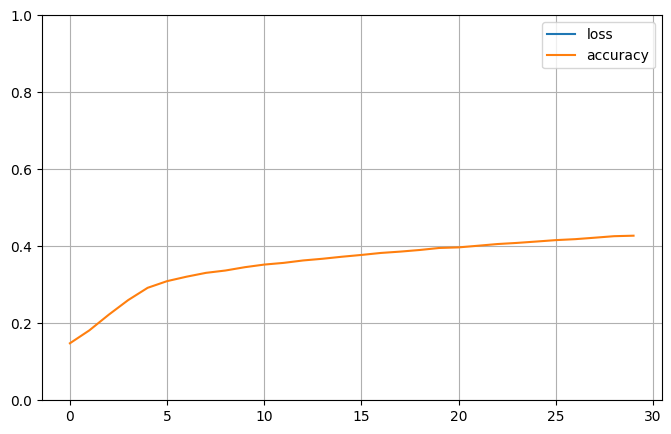

In [99]:
pd.DataFrame(history.history).plot(figsize=(8, 5))
plt.grid(True)
plt.gca().set_ylim(0, 1) # set the vertical range to [0-1]
plt.show()

In [100]:
results = model.evaluate(X, Y)
print("test loss, test acc:", results)

2500/2500 [==============================] - 10s 4ms/step - loss: 1.6082 - accuracy: 0.4319
test loss, test acc: [1.6082097291946411, 0.4318625032901764]


In [101]:
y_pred = np.argmax(model.predict(X), axis=-1)
print(y_pred)
print(y_pred[0])

print(confusion_matrix(Y, y_pred))
print(classification_report(Y, y_pred))

2500/2500 [==============================] - 10s 4ms/step
[1 5 0 ... 7 7 7]
1
[[4568  617  743  526  923  770  940  913]
 [ 393 6632  407  348  246  160 1040  774]
 [1837 1225 2292 1109  683  836 1088  930]
 [ 899  738  583 4729  414  740  943  954]
 [2202  801  865 1013 1992  936 1250  941]
 [1723  703  933 1487  659 2149 1411  935]
 [ 680 1191  366  437  429  469 5000 1428]
 [ 546  499  232  550  285  137  564 7187]]
              precision    recall  f1-score   support

           0       0.36      0.46      0.40     10000
           1       0.53      0.66      0.59     10000
           2       0.36      0.23      0.28     10000
           3       0.46      0.47      0.47     10000
           4       0.35      0.20      0.25     10000
           5       0.35      0.21      0.27     10000
           6       0.41      0.50      0.45     10000
           7       0.51      0.72      0.60     10000

    accuracy                           0.43     80000
   macro avg       0.42      0.43  

Test Accuracy:0.4318625


Text(0.5, 1.0, 'Accuracy:0.432')

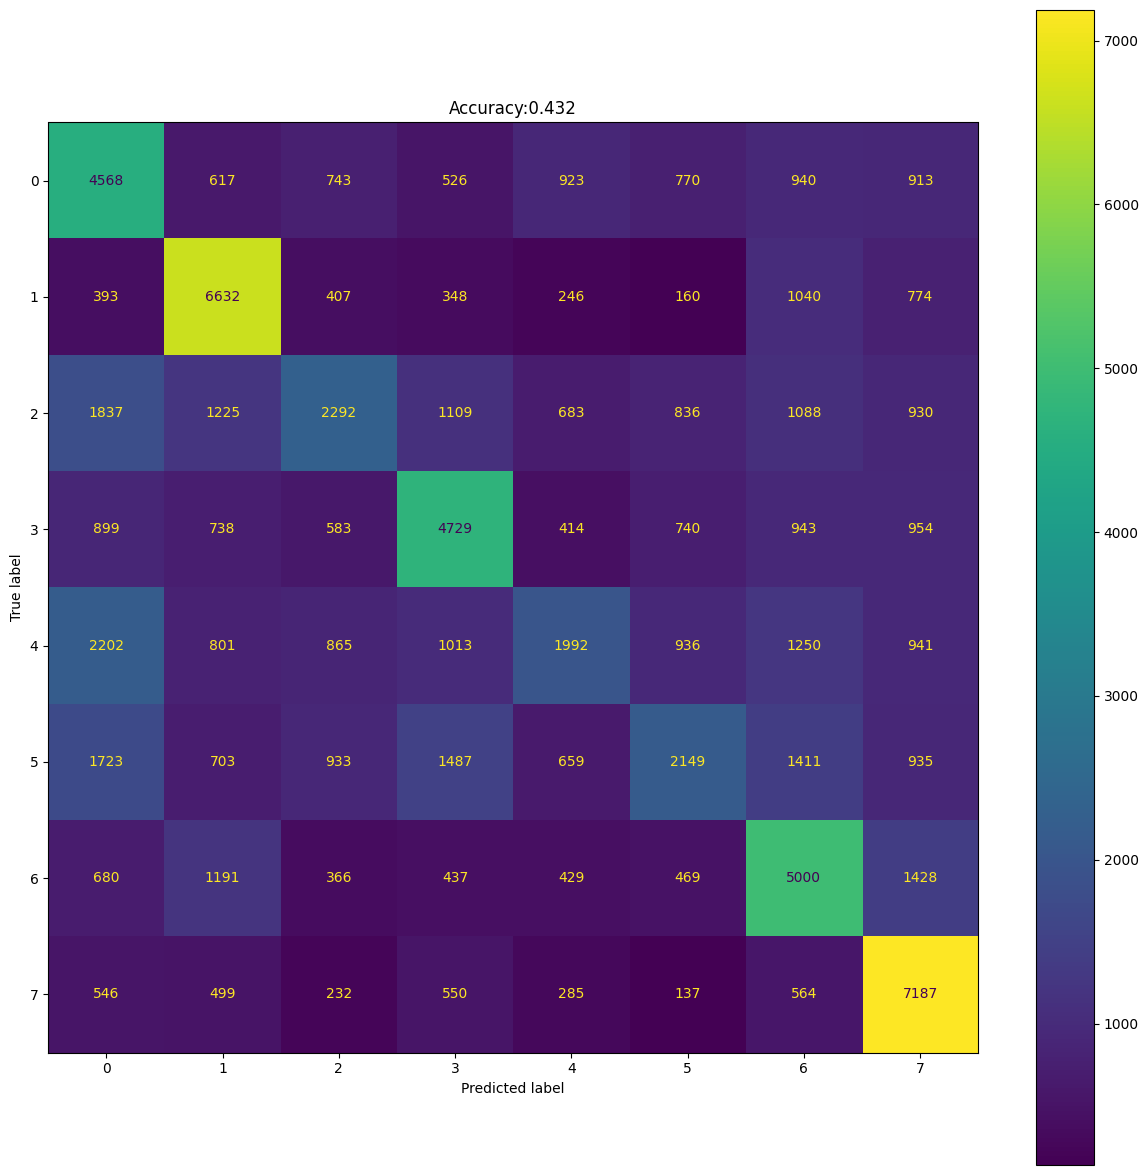

In [102]:
# confusion matrix plot
plt.rcParams["figure.figsize"] = (15,15)
fig, axs = plt.subplots(1)

test_acc = metrics.accuracy_score(y_pred,Y)
print(f"Test Accuracy:{test_acc}")
metrics.ConfusionMatrixDisplay.from_predictions(Y, y_pred, ax=axs)
plt.title(f"Accuracy:{test_acc:.3f}")
# plt.savefig(f'/Users/Lojenaa/Documents/PhD/Smartphones/Cross-device-Portability-of-EMSCA/Nordic/Device-25/iNordic-25(i)_confusion_matrix.pdf')